# Instacart Market Basket Analysis




By Paul Heysch, Kevin Liu, and Madeleine Song

12 December 2022

# Motivation


In this project, we manipulate extensive data from millions of grocery orders over hundreds of thousands of Instacart users to create various predictions about future orders and models about the different types of shoppers. 

Based on the 2017 data for grocery orders like "product name" or "hour of day", we want to see whether we will be able to train ML models able to predict an item's future popularity, detect different clusters of Instacart users, and explore what foods are ordered during which time of day. Notably, our dataset prohibits us from performing time series analysis since we do not have information regarding the dates at which specific orders were placed. 

In the meantime, we also used this opportunity to explore questions that interest us about food, eating habits, and shopping habits in general, such as which aisles and products were most popular and how individual shoppers differed in their spending habits.

Online grocery shopping has disrupted the traditional grocery retail market, and online grocery shopping is only becoming more prevalent. The analysis that we have performed is not only relevant to our personal interests but also useful in determining which products a user will buy again, try for the first time, or add to their cart next during a session. 


# Imports


In [ ]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sns.set_theme()

# Data Loading and Preprocessing

There are six tables that we need to load:

* Orders (`orders.csv`): Table of all orders and associated information (e.g. user who made the order, what time of day/week it was made during)
* Aisles (`aisles.csv`): Table of all aisles
* Products purchased in each order (or "order products")
 * Prior (`order_products__prior.csv`): Products from all prior orders from customers
 * Training (`order_products__train.csv`): Products from orders to be used for training (we combined these two `order_product` files)
* Departments (`departments.csv`): Table of all departments
* Products (`products.csv`): Table of all products, along with corresponding aisle and department IDs

In [ ]:
%cd './data'

orders = pd.read_csv('orders.csv')
aisles = pd.read_csv('aisles.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
departments = pd.read_csv('departments.csv')
products = pd.read_csv('products.csv')

/content/drive/.shortcut-targets-by-id/1xKADt7nXQzOFlPb969kYnC61XXQJvzpV/Data


Let's take a peek at the orders dataset. There is one order per row. We can see which user performed each order, but we don't know what products were included in the order.



In [ ]:
orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [ ]:
aisles.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [ ]:
order_products_prior.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [ ]:
order_products_train.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

In [ ]:
departments.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

In [ ]:
products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

## Data Cleaning

First, let's join all of the tables together into one master DataFrame to make it easier to work with the data.

In [ ]:
# Combine order_products_prior and order_products_train, and join products, aisle, and department onto the combined dataset
order_products_all = pd.concat([order_products_prior, order_products_train]).drop_duplicates()
order_products_joined = order_products_all.merge(products, how = 'left', on = 'product_id').merge(aisles, how = 'left', on = 'aisle_id').merge(departments, how = 'left', on ='department_id')
order_products_joined = order_products_joined.merge(orders[['user_id', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']], how = 'left', on = 'order_id')

In [ ]:
order_products_joined.head()

order_id  product_id  add_to_cart_order  reordered           product_name  \
0         2       33120                  1          1     Organic Egg Whites   
1         2       28985                  2          1  Michigan Organic Kale   
2         2        9327                  3          0          Garlic Powder   
3         2       45918                  4          1         Coconut Butter   
4         2       30035                  5          0      Natural Sweetener   

   aisle_id  department_id               aisle  department  user_id  \
0        86             16                eggs  dairy eggs   202279   
1        83              4    fresh vegetables     produce   202279   
2       104             13   spices seasonings      pantry   202279   
3        19             13       oils vinegars      pantry   202279   
4        17             13  baking ingredients      pantry   202279   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  
0             3          5                  9                     8.0  
1             3          5                  9                     8.0  
2             3          5                  9                     8.0  
3             3          5                  9                     8.0  
4             3          5                  9                     8.0

Now, let's check if there are any missing values in any of the columns. (For the following parts, our main data frame will be this order products data frame, so we'll rename it as just `df` for convenience.)

In [ ]:
df = order_products_joined
print(df.shape)
df.isna().sum()

(33819106, 14)


order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
user_id                         0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64

Fortunately, most of the columns have no null values, with the exception of `days_since_prior_order`. We suspect that such null values represent customers making first-time orders. Note that these order products account for about 2 million order products out of a total of 33 million+ order products.

# EDA

One of the key insights we want to gain from EDA is how different features are distributed. To that end, let's begin by looking at the unique values in each column.

In [ ]:
df.nunique()

order_id                  3346083
product_id                  49685
add_to_cart_order             145
reordered                       2
product_name                49685
aisle_id                      134
department_id                  21
aisle                         134
department                     21
user_id                    206209
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64

In [ ]:
for col in df.columns[-6:]:
  print(col)
  print(np.sort(df[col].unique()))
  print('_' * 50)

department
['alcohol' 'babies' 'bakery' 'beverages' 'breakfast' 'bulk' 'canned goods'
 'dairy eggs' 'deli' 'dry goods pasta' 'frozen' 'household'
 'international' 'meat seafood' 'missing' 'other' 'pantry' 'personal care'
 'pets' 'produce' 'snacks']
__________________________________________________
user_id
[     1      2      3 ... 206207 206208 206209]
__________________________________________________
order_number
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
__________________________________________________
order_dow
[0 1 2 3 4 5 6]
__________________________________________________
order_hour_of_day
[ 0  1  2  3  4  5  6  7  8

These numbers tell us some useful information about the columns. For example, we note that there are 7 possible days of the week and 24 hours of the day, which make sense. We also note that `order_number` is capped at 100 and that `days_since_prior_order` is capped at 30.

Let's take a closer look at some of these columns by asking some guiding questions:
* When and how often do customers place orders?
* What kinds of products do customers buy?

Note that each row in the DataFrame represents a product of an order, not an order, so our analysis below really looks at when and what individual products are bought.

## When and how often do customers place orders?

First, let's look at when customers like to place orders during the day.

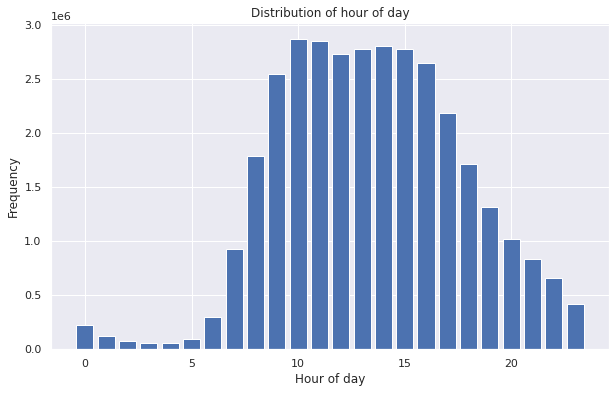

In [ ]:
vc = df['order_hour_of_day'].value_counts()

plt.bar(x=vc.index, height=vc.values)
plt.title('Distribution of hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Frequency')
plt.gcf().set_size_inches(10, 6)
plt.show()

We see that customers like to place orders during the middle of the day, between hours 10 (10:00 AM) and 17 (5:00 PM), which is to be expected.

Now, let's look at when customers place orders during the week.

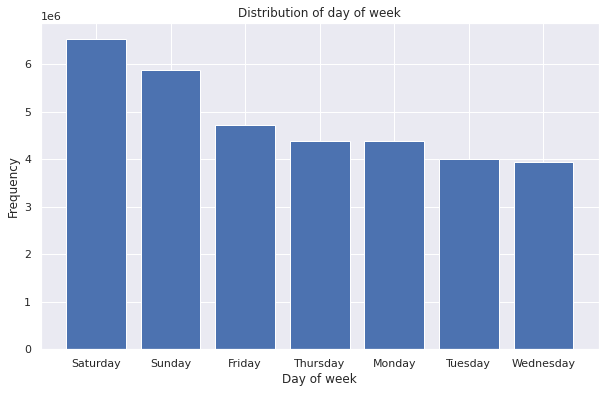

In [ ]:
dow_map = {
    0: 'Saturday',
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
}
vc = df['order_dow'].map(dow_map).value_counts()

plt.bar(x=vc.index, height=vc.values)
plt.title('Distribution of day of week')
plt.xlabel('Day of week')
plt.ylabel('Frequency')
plt.gcf().set_size_inches(10, 6)
plt.show()

This distribution is a little more uniform than the previous one. However, there's still a noticeable increase on Saturdays and Sundays, suggesting that customers are more likely to place orders in the middle of the week. This makes sense, since they have more free time during the weekends.

Now we know that the majority of orders are made during the daytime over the weekends. Can we see the order distribution in both the day of the week and the hour of the day?

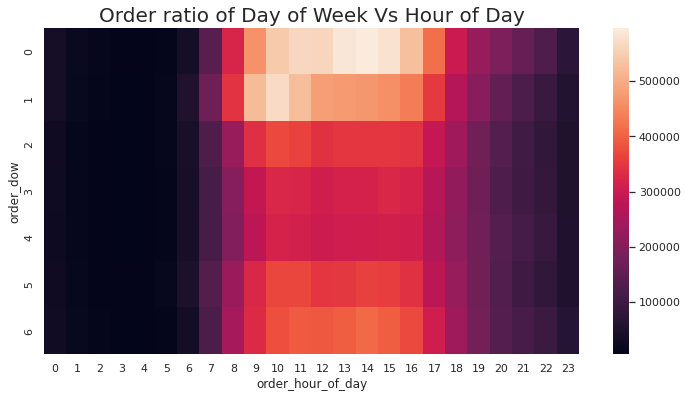

In [ ]:
grouped_df = df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Order ratio of Day of Week Vs Hour of Day", fontsize=20)
plt.show()

Interestingly, we see that the most orders are either placed in the *evening* on Saturday or in the *morning* on Sunday. This adds more nuance to our previous assumptions that orders were made more frequently during the middle of the day. 

Now, let's look at how *often* customers place orders. The `days_since_prior_order` should tell us a lot of information about this, but we need to keep in mind that it is capped at 30 days. Also, remember that there are null values (i.e. customers making first-time orders), which account for ~2m out of a total of 33m+ orders. We drop these null values here in order to plot the distribution of the remaining orders.

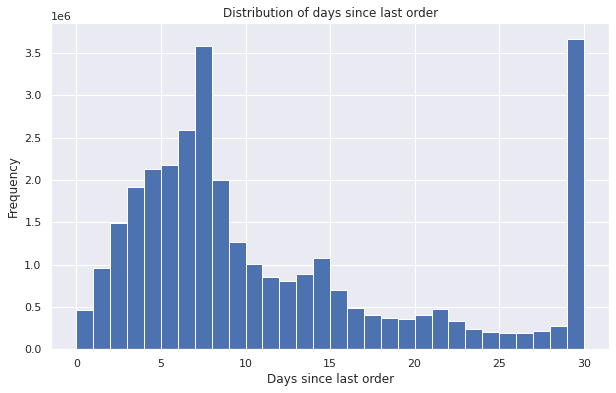

In [ ]:
plt.hist(df['days_since_prior_order'].dropna(), bins=range(31))
plt.title('Distribution of days since last order')
plt.xlabel('Days since last order')
plt.ylabel('Frequency')
plt.gcf().set_size_inches(10, 6)
plt.show()

It looks many customers don't wait more than 7 days before ordering again. Moreover, there are two peaks of interest here:
* There is a peak at 30 days, which makes sense given that the column is capped at 30 days. This means that many customers rarely order, i.e. wait more than 1 month between orders.
* There is a peak at 7 days. This is also interesting, since it provides evidence that some customers may order regularly, i.e. they like to buy groceries on a weekly schedule.

Now, let's look at the distribution of order numbers, i.e. how many orders the customer has placed up through the order in question. Remember, this is capped at 100 orders.

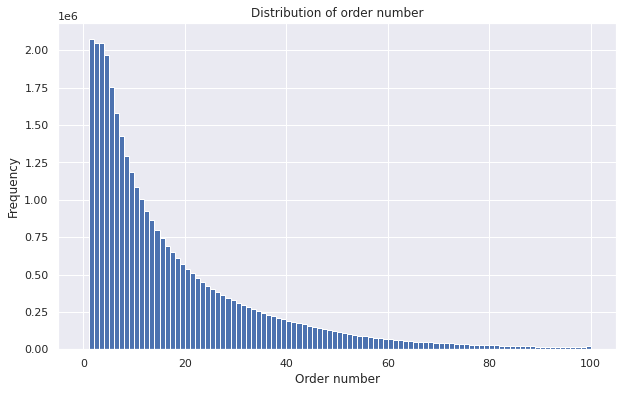

In [ ]:
plt.hist(df['order_number'], bins=range(101))
plt.title('Distribution of order number')
plt.xlabel('Order number')
plt.ylabel('Frequency')
plt.gcf().set_size_inches(10, 6)
plt.show()

There is a clear trend here: Customers are less likely to have higher order numbers. This makes sense, since, as the order number `n` increases, we expect there to be fewer customers that have made at least `n` orders. (Note that there is a tiny peak at 100, indicating the cap at 100 orders.)

## What kinds of products do customers buy?

Let's take a look at how purchases are distributed by department.

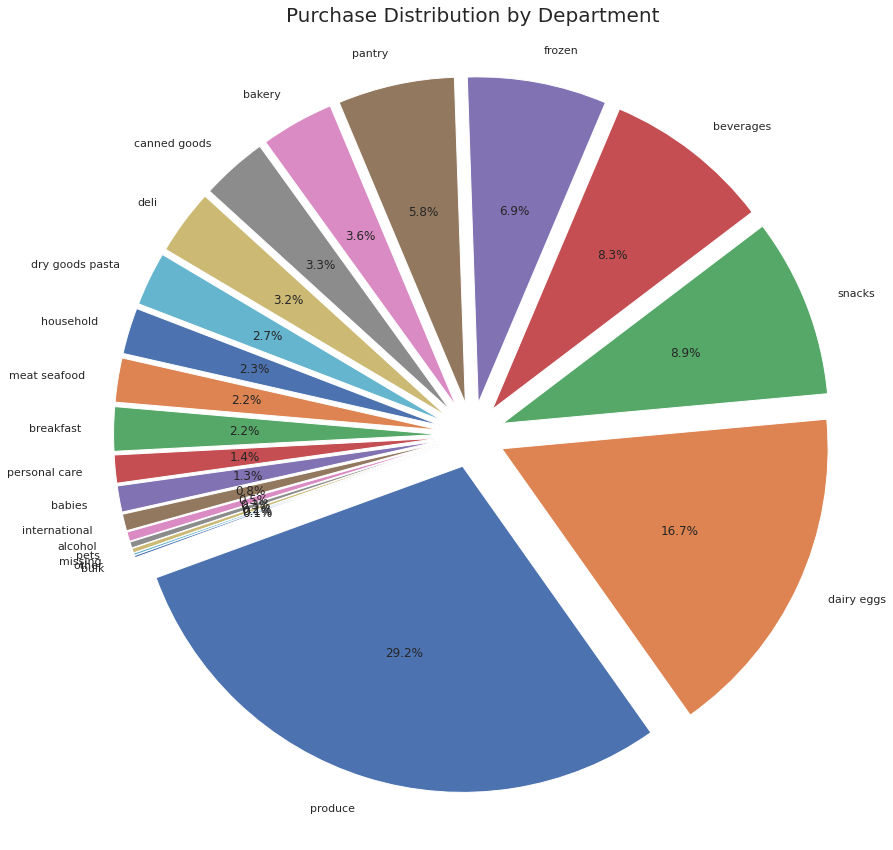

In [ ]:
vc = df['department'].value_counts()
plt.figure(figsize=(15,15))
labels = vc.index
sizes = (np.array((vc / vc.sum())*100))
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)

plt.pie(sizes, explode=explode, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Purchase Distribution by Department", fontsize=20)
plt.show()



We see that the most common kinds of products ordered are produce (almost 30% of orders), followed by dairy/eggs (~16%). This makes sense, since most customers look for fresh produce, dairy, and eggs on a grocery shopping trip. These items are also expire more quickly, and therefore must be purchased more frequently, then staples such as canned goods, dried pasta, or frozen goods. 

Now we know which departments are most likely to be ordered from. But which departments are most likely to be **reordered** from? 

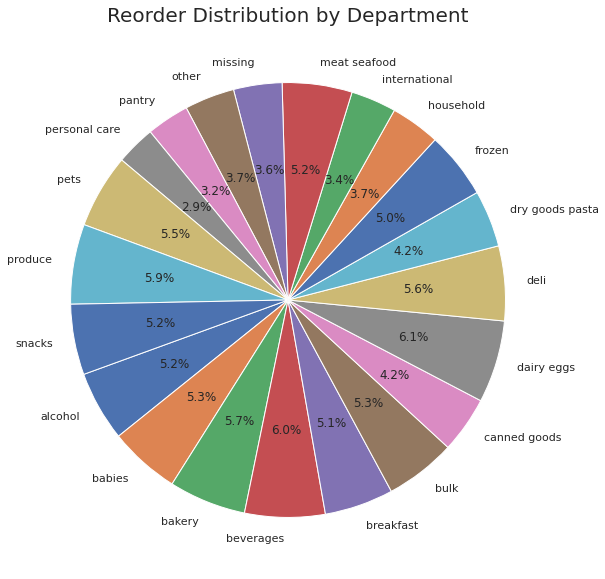

In [ ]:
grouped_df = df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(10,10))
labels = grouped_df['department'].values
sizes = grouped_df['reordered'].values
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Reorder Distribution by Department", fontsize=20)
plt.show()

Let's go more in-depth and look at the actual aisles. Before we look at the distribution, however, let's first take a look at which aisles fall in which departments.

In [ ]:
pd.set_option('display.max_rows', None)
print(df.groupby(['department', 'aisle'])['order_id'].count() / df.shape[0] * 100) # Display percentages
pd.reset_option('display.max_rows')

department       aisle                        
alcohol          beers coolers                     0.149312
                 red wines                         0.107702
                 specialty wines champagnes        0.034475
                 spirits                           0.085954
                 white wines                       0.093574
babies           baby accessories                  0.025033
                 baby bath body care               0.026343
                 baby food formula                 1.169913
                 diapers wipes                     0.076034
bakery           bakery desserts                   0.107549
                 bread                             1.799187
                 breakfast bakery                  0.770632
                 buns rolls                        0.349119
                 tortillas flat bread              0.596261
beverages        cocoa drink mixes                 0.065868
                 coffee                            0.

Here, we have gathered a comprehensive list of each aisle and its corresponding department, as well as the percentage of orders it corresponds to. We know from above that produce makes up a plurality of the orders - indeed, scrolling down to the produce section, we see that fresh fruits and fresh vegetables each make up over 10% of all orders.

With this in mind, let's visualize these data to have a better understanding of this distribution.

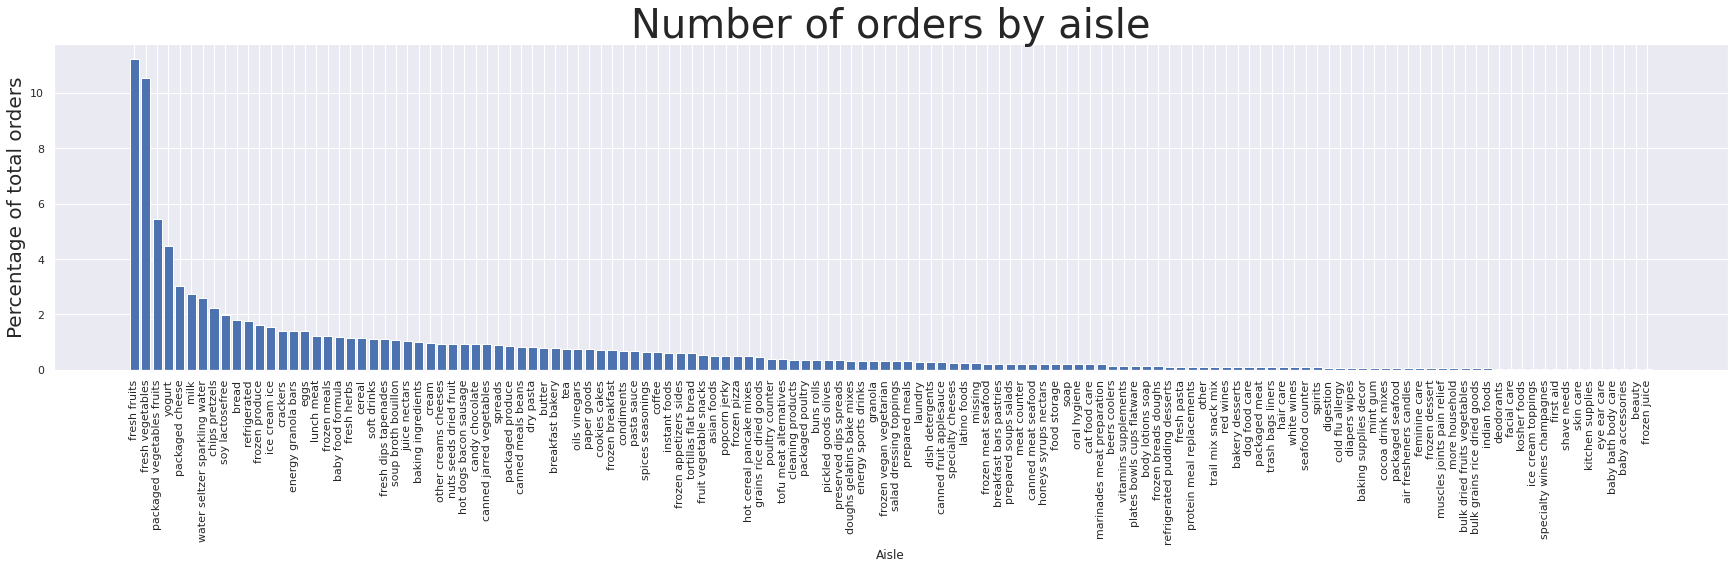

In [ ]:
vc = df['aisle'].value_counts()
plt.bar(vc.index, vc.values / df.shape[0] * 100)
plt.title('Number of orders by aisle', fontsize=40)
plt.xlabel('Aisle')
plt.ylabel('Percentage of total orders', fontsize=20)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(30, 6)
plt.show()

As we saw above, fresh fruits and fresh vegetables are by the most commonly ordered aisles, each accounting for more than 10% of total orders (which is a lot when you consider that there are 134 aisles in total!).



Finally, let's go into even more detail and see which products were the most popular. Note that there are almost 50,000 products, so it's best to just look at the top products instead of trying to obtain counts for every single product. (Even with the aisles above, the counting got a little messy.)

In [ ]:
df['product_name'].value_counts()[:10]

Banana                    491291
Bag of Organic Bananas    394930
Organic Strawberries      275577
Organic Baby Spinach      251705
Organic Hass Avocado      220877
Organic Avocado           184224
Large Lemon               160792
Strawberries              149445
Limes                     146660
Organic Whole Milk        142813
Name: product_name, dtype: int64

It looks most of the top 10 products are fresh fruits and fresh vegetables, which of course supports our previous findings.



## How do individual customers differ?

In this part of the analysis, we're going to group our data by the `user_id` column, which can allows us to differentiate betweeen customers with a high/low number of orders, customers that shop at regular, predictables times and days and those that have no clear shopping pattern, customers that prefer certain aisles and departments, and more. 

### Processing the data with Spark

Due to the relatively large size of the dataset (~34M rows), we'll need to make use of Spark to perform the group-bys required for this analysis. Trying to perform a group by on the entire dataset directly in Colab actually uses all of the RAM available and crashes the session almost all of the time!

In [ ]:
!apt install libkrb5-dev
!pip install sparkmagic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
0 upgraded, 7 newly installed, 0 to remove and 20 not upgraded.
Need to get 349 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ubuntu0.2 [54.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkdb5-9 amd64 1.16-2ubuntu0.2 [37.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
%spark add -s spark_session -l python -u http://ec2-3-84-213-203.compute-1.amazonaws.com -a cis545-livy -p AbUrbeCondita -t Basic_Access

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


We've gone ahead and saved the order products dataset to S3 so that we can easily load it.

In [ ]:
%%spark
order_products_sdf = spark.read.option("header", True).csv("s3://project-3-emrlogsbucket-1ctrzvdev5yqa/order_products_joined.csv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
order_products_sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+--------+----------+-----------------+---------+--------------------+--------+-------------+--------------------+-------------+-------+------------+---------+-----------------+----------------------+
|_c0|order_id|product_id|add_to_cart_order|reordered|        product_name|aisle_id|department_id|               aisle|   department|user_id|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+---+--------+----------+-----------------+---------+--------------------+--------+-------------+--------------------+-------------+-------+------------+---------+-----------------+----------------------+
|  0|       2|     33120|                1|        1|  Organic Egg Whites|      86|           16|                eggs|   dairy eggs| 202279|           3|        5|                9|                   8.0|
|  1|       2|     28985|                2|        1|Michigan Organic ...|      83|            4|    fresh vegetables|      produce| 202279|           3|        5|                9

Let's now use SparkSQL to group this dataset by user_id and extract the user-level features we're interested in.

Note that, to avoid running out of memory in the cluster, we split our features of interest into two subsets and run separate queries for each to get two smaller tables.

In [ ]:
%%spark
order_products_sdf.createOrReplaceTempView('order_products_sql')

query = ''' SELECT order_products_sql.user_id, count(distinct order_products_sql.product_id) as n_unique_products_ordered, count(distinct order_products_sql.department_id) as n_unique_departments_visited, 
                count(distinct order_products_sql.order_dow) as n_weekdays_ordered_on, 
                count(distinct order_products_sql.order_hour_of_day) as n_hoursofday_ordered_on
                from order_products_sql 
                group by order_products_sql.user_id'''
grouped_user_sdf1 = spark.sql(query)
grouped_user_sdf1.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------------+----------------------------+---------------------+-----------------------+
|user_id|n_unique_products_ordered|n_unique_departments_visited|n_weekdays_ordered_on|n_hoursofday_ordered_on|
+-------+-------------------------+----------------------------+---------------------+-----------------------+
|  68325|                       94|                          16|                    5|                     10|
|  47140|                       36|                          11|                    4|                      5|
|  14369|                      142|                          11|                    6|                     11|
|  94102|                       71|                          14|                    7|                     10|
| 134851|                       68|                          14|                    5|                      6|
| 122022|                      127|                          16|                    7|                     15|
|

In [ ]:
%%spark
query = ''' SELECT order_products_sql.user_id, count(distinct order_products_sql.order_id) as total_orders, 
                count(*) as total_items_ordered, 
                avg(order_products_sql.days_since_prior_order) as average_days_between_orders, stddev(order_products_sql.days_since_prior_order) as sd_days_between_orders
                from order_products_sql 
                group by order_products_sql.user_id'''
grouped_user_sdf2 = spark.sql(query)
grouped_user_sdf2.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+-------------------+---------------------------+----------------------+
|user_id|total_orders|total_items_ordered|average_days_between_orders|sd_days_between_orders|
+-------+------------+-------------------+---------------------------+----------------------+
| 140082|           8|                214|         22.710526315789473|     6.191425606778891|
| 104603|           5|                 38|          26.10810810810811|     4.053693677676254|
|  89771|          18|                249|         12.731601731601732|      6.10678856304491|
| 204835|           4|                  9|                       16.0|     3.265986323710905|
|  47919|          31|                171|         10.128834355828221|    3.4839087585389974|
| 154645|          98|               1117|          4.134913400182316|    3.6229742410166637|
| 121867|          22|                321|         13.143812709030101|     8.003945347087697|
|  48078|          17|                142|          8.691176

Let's take a look at the size (number of rows) in the data frames. Then, we can output them in Pandas and save them as CSVs files for future use.

In [ ]:
%%spark
grouped_user_sdf1.createOrReplaceTempView('gu')
spark.sql('select count(*) from gu').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|count(1)|
+--------+
|  206210|
+--------+

In [ ]:
%%spark
grouped_user_sdf2.createOrReplaceTempView('gu')
spark.sql('select count(*) from gu').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|count(1)|
+--------+
|  206210|
+--------+

In [ ]:
%spark -o grouped_user_sdf1 -n 207000

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%spark -o grouped_user_sdf2 -n 207000

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
grouped_user_sdf1.to_csv('grouped_user1_df.csv')

In [ ]:
grouped_user_sdf2.to_csv('grouped_user2_df.csv')

Now, it would also be interesting to have a feature that tells us what each user's favorite product is - let's find this.

First, let's group by user and see how many of every single product each person ordered.

In [ ]:
%%spark

prod_counts_sdf = order_products_sdf.groupby(['user_id', 'product_name']).count().alias('count')
prod_counts_sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-----+
|user_id|        product_name|count|
+-------+--------------------+-----+
| 124742| Whole Wheat Fig Bar|    5|
| 145686|     Organic Avocado|   10|
| 123154|Organic Romaine H...|    3|
|  69612|          Cane Sugar|    1|
| 133331|    Red Leaf Lettuce|    1|
| 174038|Organic Red On th...|    2|
|  35907| Peppered Beef Jerky|    4|
|  93145|      Collard Greens|    2|
|  59899| Dark Sweet Cherries|    2|
|  35109|Organic Multigrai...|    3|
|  86755|      Chickpea Salad|    3|
|  98859|          Diet Pepsi|   17|
| 162148| Organic Purple Kale|    2|
| 101204|               Limes|   19|
| 196064|Garlic Marinara P...|    5|
|  47892|Citrus Mandarins ...|    3|
|  11797|Organic Spring Mi...|    5|
| 164404|Italian Dill Spea...|   14|
| 192974|Goldfish Cheddar ...|    5|
|  88236|Total 2% Lowfat G...|   10|
+-------+--------------------+-----+
only showing top 20 rows

Let's narrow this down to each user's favorite product.

In [ ]:
%%spark

prod_counts_sdf.createOrReplaceTempView('prod_counts_sql')

query = '''
SELECT prod_counts_sql.user_id, prod_counts_sql.product_name, prod_counts_sql.count
    FROM prod_counts_sql
    JOIN (SELECT user_id, MAX(count) AS max_count
        FROM prod_counts_sql
        GROUP BY user_id) AS t
    ON prod_counts_sql.user_id = t.user_id AND prod_counts_sql.count = t.max_count
'''

user_fav_prod = spark.sql(query)
user_fav_prod.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-----+
|user_id|        product_name|count|
+-------+--------------------+-----+
| 145551|        Strawberries|   10|
|  87802|              Banana|   10|
|  53718|Apple Honeycrisp ...|    9|
|  22056|        Turkey Bacon|    4|
|  84383|Organic Grade A F...|    1|
|  39665|        Low Fat Milk|    2|
| 162288|  Organic Eggs Large|    2|
|  30546| Red Seedless Grapes|    2|
|  16027|        Pesto Swirls|    1|
|  88912|Garden Vegetable ...|    1|
|  16027| Organic Roma Tomato|    1|
| 154000|Total 0% Nonfat G...|    6|
| 140907|Michigan Organic ...|    7|
|  77768|        Spring Water|    6|
|   3488|Organic Roasted R...|    6|
| 129990|Gluten Free Crack...|    6|
| 157574|Smoked Turkey Bre...|    5|
|  41554|Organic Unbleache...|    3|
| 174083|      Cucumber Kirby|    2|
|  18473|Corn Sweet Potato...|    4|
+-------+--------------------+-----+
only showing top 20 rows

In [ ]:
%%spark
user_fav_prod.createOrReplaceTempView('ufp')
spark.sql('select count(*) from ufp').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|count(1)|
+--------+
|  363047|
+--------+

Note that, while there are about 200,000 unique users, some users had multiple favorite products (i.e. multiple products that matched their max product count). We kept all of these products, which explains why this table's size is actually around 360,000. (A similar effect (to a lesser extent) can be seen below, when we find each user's favorite department(s) and aisle(s).)

Now, let's output the data frame to Pandas and save it as a CSV file for future use.

In [ ]:
%spark -o user_fav_prod -n 400000

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
user_fav_prod.to_csv('user_fav_prod_df.csv')

We can repeat the same procedure to determine what each user's favorite department is...

In [ ]:
%%spark

dep_counts_sdf = order_products_sdf.groupby(['user_id', 'department']).count().alias('count')
dep_counts_sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------+-----+
|user_id|   department|count|
+-------+-------------+-----+
|  30527|   dairy eggs|   56|
|  49043|       bakery|   75|
|  83323|       pantry|   20|
| 165896|   dairy eggs|   45|
| 199382|       snacks|   55|
| 193495|       frozen|   12|
|  74160|       bakery|   23|
|  45647|      produce|   97|
| 182653|      produce|  182|
|   1659|       frozen|   38|
| 172112|      produce|   32|
| 170914|       bakery|   24|
|  95933|       pantry|    4|
|  27297|    beverages|   14|
| 150206|         deli|    3|
|  85014|       pantry|   30|
| 162722|      produce|  415|
|  81755|       frozen|  104|
| 173231|personal care|    4|
| 149142|       pantry|   46|
+-------+-------------+-----+
only showing top 20 rows

In [ ]:
%%spark

dep_counts_sdf.createOrReplaceTempView('dep_counts_sql')

query = '''
SELECT dep_counts_sql.user_id, dep_counts_sql.department, dep_counts_sql.count
    FROM dep_counts_sql
    JOIN (SELECT user_id, MAX(count) AS max_count
        FROM dep_counts_sql
        GROUP BY user_id) AS t
    ON dep_counts_sql.user_id = t.user_id AND dep_counts_sql.count = t.max_count
'''

user_fav_dep = spark.sql(query)
user_fav_dep.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+-----+
|user_id|department|count|
+-------+----------+-----+
|   6687|    snacks|   22|
|  93734|dairy eggs|   10|
|  80137|   produce|   24|
| 123877|   alcohol|   18|
|    409|   produce|  370|
|  92435|   produce|   33|
| 114711|   produce|  262|
| 182937|    frozen|   26|
|  30101|   produce|   38|
|  48193|   produce|   15|
| 195739|   produce|   18|
|  39404|dairy eggs|   10|
|  67899| beverages|    9|
|  98300|   produce|   36|
|  31409|   produce|   56|
| 133987|    pantry|    5|
|  39257|dairy eggs|  143|
|  80114|    snacks|    5|
| 143534|   produce|   25|
|  31779|    bakery|    5|
+-------+----------+-----+
only showing top 20 rows

In [ ]:
%%spark
user_fav_dep.createOrReplaceTempView('ufd')
spark.sql('select count(*) from ufd').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|count(1)|
+--------+
|  216637|
+--------+

In [ ]:
%spark -o user_fav_dep -n 250000

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
user_fav_dep.to_csv('user_fav_dep_df.csv')

...and what each user's favorite aisle is.

In [ ]:
%%spark

aisle_counts_sdf = order_products_sdf.groupby(['user_id', 'aisle']).count().alias('count')
aisle_counts_sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-----+
|user_id|               aisle|count|
+-------+--------------------+-----+
|  58701|        fresh fruits|   81|
| 158728|               cream|    2|
| 151207|    fresh vegetables|   34|
|  84876|              butter|   15|
|  25883|    packaged poultry|    5|
|  71771|                milk|    8|
|  20829|prepared soups sa...|    4|
|  72163|    packaged poultry|    3|
| 189408|    fresh vegetables|  101|
| 187589|hot cereal pancak...|    8|
| 119134|     packaged cheese|   49|
|  11912|    packaged poultry|   34|
| 113312|frozen vegan vege...|    5|
|  10351|    fresh vegetables|   25|
| 165810|              yogurt|  109|
|  15169|    fresh vegetables|  168|
| 155941|     soy lactosefree|   10|
|  29274|       cookies cakes|   11|
|  26145|water seltzer spa...|   45|
| 156712| energy granola bars|   69|
+-------+--------------------+-----+
only showing top 20 rows

In [ ]:
%%spark

aisle_counts_sdf.createOrReplaceTempView('aisle_counts_sql')

query = '''
SELECT aisle_counts_sql.user_id, aisle_counts_sql.aisle, aisle_counts_sql.count
    FROM aisle_counts_sql
    JOIN (SELECT user_id, MAX(count) AS max_count
        FROM aisle_counts_sql
        GROUP BY user_id) AS t
    ON aisle_counts_sql.user_id = t.user_id AND aisle_counts_sql.count = t.max_count
'''

user_fav_aisle = spark.sql(query)
user_fav_aisle.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-----+
|user_id|               aisle|count|
+-------+--------------------+-----+
|  91224|                milk|   75|
|  54305|        fresh fruits|   13|
|  77226|        fresh fruits|    5|
| 147697|    fresh vegetables|   41|
|  48337|    fresh vegetables|  123|
| 148602|hot dogs bacon sa...|    2|
|  11989|nuts seeds dried ...|    5|
| 186649|   cleaning products|    2|
| 172853|              yogurt|    9|
|  40768|    fresh vegetables|    9|
|  46186|        fresh fruits|  134|
| 176519|        fresh fruits|   30|
| 153273|    fresh vegetables|   68|
| 186674|        fresh fruits|   10|
| 163414|    fresh vegetables|   16|
|   6563|     packaged cheese|   29|
| 169239|     soy lactosefree|   21|
|  23645|    fresh vegetables|   21|
|  12654|    fresh vegetables|   10|
|   3488|       ice cream ice|    6|
+-------+--------------------+-----+
only showing top 20 rows

In [ ]:
%%spark
user_fav_aisle.createOrReplaceTempView('ufa')
spark.sql('select count(*) from ufa').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|count(1)|
+--------+
|  235398|
+--------+

In [ ]:
%spark -o user_fav_aisle -n 250000

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
user_fav_aisle.to_csv('user_fav_aisle_df.csv')

### Visualizations

In [ ]:
grouped_user_df1 = pd.read_csv('grouped_user1_df.csv').drop(columns='Unnamed: 0')
grouped_user_df2 = pd.read_csv('grouped_user2_df.csv').drop(columns='Unnamed: 0')
user_fav_prod_df = pd.read_csv('user_fav_prod_df.csv').drop(columns='Unnamed: 0')
user_fav_dep_df = pd.read_csv('user_fav_dep_df.csv').drop(columns='Unnamed: 0')
user_fav_aisle_df = pd.read_csv('user_fav_aisle_df.csv').drop(columns='Unnamed: 0')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
grouped_user_df = grouped_user_df1.merge(grouped_user_df2, on='user_id')
grouped_user_df

user_id  n_unique_products_ordered  n_unique_departments_visited  \
0        68325                         94                            16   
1        40874                         49                            11   
2       196082                         56                            11   
3        51244                        106                            15   
4        74605                        210                            18   
...        ...                        ...                           ...   
206033  149441                          6                             3   
206034   62345                         12                             6   
206035  143034                          2                             2   
206036   56668                          4                             4   
206037  178456                          3                             2   

        n_weekdays_ordered_on  n_hoursofday_ordered_on  total_orders  \
0                           5                       10            19   
1                           6                        9            14   
2                           6                        9             9   
3                           7                       12            22   
4                           6                       15            50   
...                       ...                      ...           ...   
206033                      4                        4             4   
206034                      4                        5             5   
206035                      2                        4             4   
206036                      3                        3             4   
206037                      3                        4             4   

        total_items_ordered  average_days_between_orders  \
0                       296                    15.055944   
1                       164                    24.261745   
2                        62                    18.457627   
3                       243                    16.560870   
4                       503                     8.198397   
...                     ...                          ...   
206033                   10                    25.857143   
206034                   20                    25.000000   
206035                    4                    19.333333   
206036                    9                    23.666667   
206037                   10                    30.000000   

        sd_days_between_orders  
0                     9.101206  
1                     6.678319  
2                     6.981063  
3                    11.130164  
4                     7.096772  
...                        ...  
206033                6.011893  
206034                5.585696  
206035               12.220202  
206036                6.345602  
206037                0.000000  

[206038 rows x 9 columns]

Let's do a little more EDA around this user-level dataset.

First, let's look at the distribution of the number of unique individual products ordered per user.



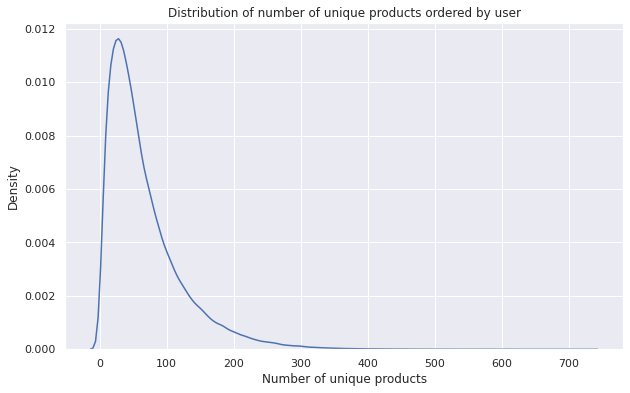

51.0


In [ ]:
sns.kdeplot(grouped_user_df['n_unique_products_ordered'])
plt.title('Distribution of number of unique products ordered by user')
plt.xlabel('Number of unique products')
plt.tick_params(bottom = False)
plt.gcf().set_size_inches(10, 6)
plt.show()
print(grouped_user_df.n_unique_products_ordered.median())

As we can expect, this distribution is quite skewed to the left. We can also take a look at the number of number of unique departments each user has visited.

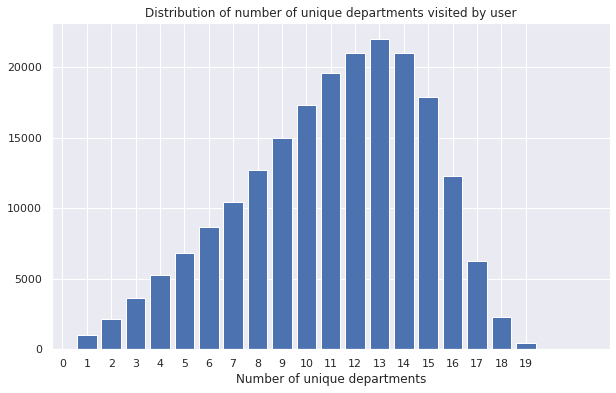

In [ ]:
vc = grouped_user_df['n_unique_departments_visited'].value_counts()
plt.bar(x=vc.index, height=vc.values)
plt.title('Distribution of number of unique departments visited by user')
plt.xlabel('Number of unique departments')
plt.xticks(np.arange(20))
plt.gcf().set_size_inches(10, 6)
plt.show()

Interestingly, this looks more balanced, with the average user making orders from 10-15 different departments.

Let's examine the distribution of unique weekdays that users have placed their orders on.

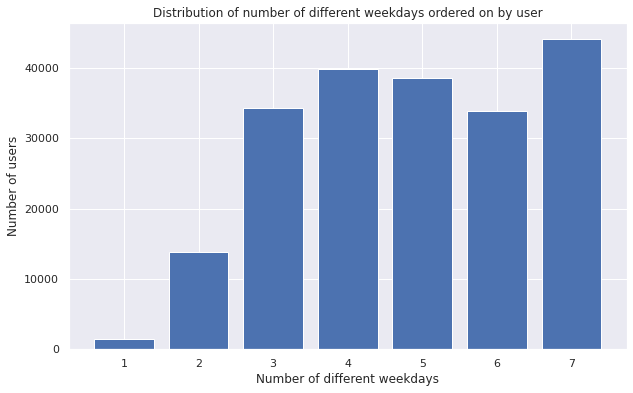

In [ ]:
vc = grouped_user_df['n_weekdays_ordered_on'].value_counts()
plt.bar(x=vc.index, height=vc.values)
plt.title('Distribution of number of different weekdays ordered on by user')
plt.xlabel('Number of different weekdays')
plt.ylabel('Number of users')
plt.gcf().set_size_inches(10, 6)
plt.show()

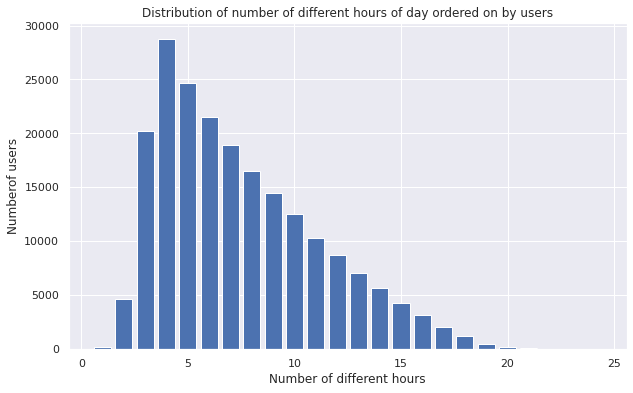

In [ ]:
vc = grouped_user_df['n_hoursofday_ordered_on'].value_counts()
plt.bar(x=vc.index, height=vc.values)
plt.title('Distribution of number of different hours of day ordered on by users')
plt.xlabel('Number of different hours')
plt.ylabel('Numberof users')
plt.gcf().set_size_inches(10, 6)
plt.show()

What this exploration is telling us so far is that there doesn't seem to be much of a pattern of users being "regular" shoppers who have their routines of ordering on a specific day or even time of day. Let's now look at little more at the relationships between some of these features.

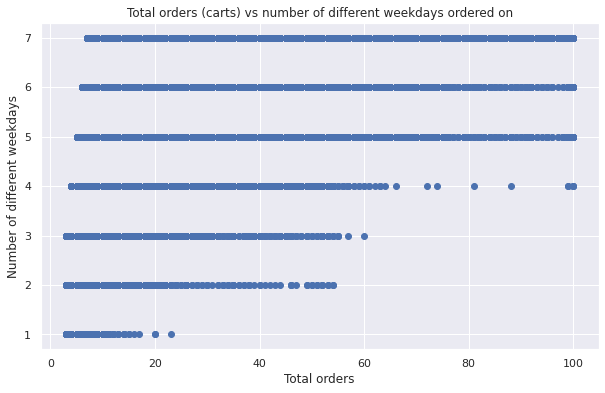

In [ ]:
plt.scatter(x = grouped_user_df['total_orders'], y = grouped_user_df['n_weekdays_ordered_on'])
plt.title('Total orders (carts) vs number of different weekdays ordered on')
plt.xlabel('Total orders')
plt.ylabel('Number of different weekdays')
plt.gcf().set_size_inches(10, 6)
plt.show()

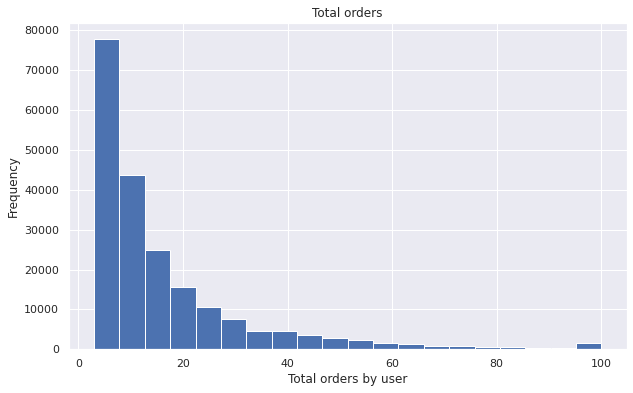

In [ ]:
plt.hist(grouped_user_df['total_orders'], bins = 20)
plt.title('Total orders')
plt.xlabel('Total orders by user')
plt.ylabel('Frequency')
plt.gcf().set_size_inches(10, 6)
plt.show()

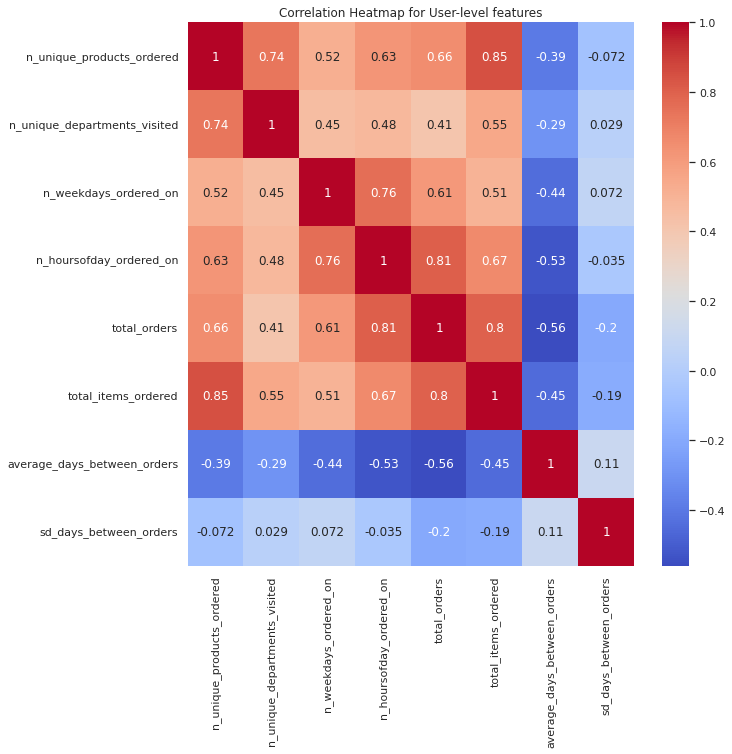

In [ ]:
corr_df = grouped_user_df.drop(columns=['user_id']).corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr_df, annot = True, cmap = 'coolwarm')
plt.title("Correlation Heatmap for User-level features")
plt.show()

We see that the first six features have positive correlations with each other, which makes sense since they should be generally all be higher for users that are more active. On the other hand, they are negatively correlated with the average number of days between orders - in other words, more active users are tend to wait shorter periods of time before ordering again. The standard deviation of the number of days between orders does not seem to be highly correlated with any other feature.

Now, let's look at the distributions of the users' favorite products, departments, and aisles.

Note that, to avoid throwing away data, we have left in all the cases in which a user had multiple favorites. This means some users contributed more to the distribution, but the overall trends should still be clear.

In [ ]:
user_fav_prod_df['product_name'].value_counts() / user_fav_prod_df.shape[0] * 100

Banana                                     4.701595
Bag of Organic Bananas                     2.791925
Organic Baby Spinach                       1.146959
Organic Avocado                            1.143929
Organic Whole Milk                         0.995739
                                             ...   
Extra Strong 30 Gallon Large Trash Bags    0.000275
Chocolate Cupcakes                         0.000275
Decaffeinated Irish Breakfast Tea Bags     0.000275
Organic French Beans                       0.000275
Organic Mochi                              0.000275
Name: product_name, Length: 23838, dtype: float64

At the product level, we observe similar trends. The most popular favorites are fresh fruits and vegetables, which supports our previous findings on the order products data frame.

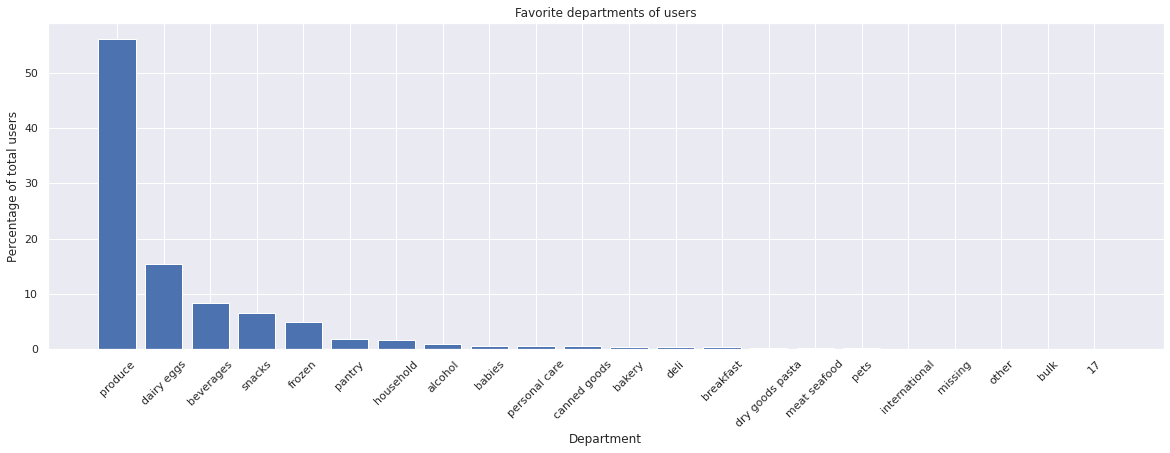

In [ ]:
vc = user_fav_dep_df['department'].value_counts()
plt.bar(x=vc.index, height=vc.values / user_fav_dep_df.shape[0] * 100)
plt.title('Favorite departments of users')
plt.xlabel('Department')
plt.ylabel('Percentage of total users')
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 6)
plt.show()

Likewise, we see that fresh produce is the most popular department for users, since the majority users buy fresh produce most often. This again supports our previous finding that fresh produce is most popular department among all order products.

Note that the top percentage is a little higher here (about 55%) at the user level than at the order product level (about 30%), since we're looking strictly at each user's favorites and not considering orders in any other department. A similar effect can be observed above for the favorite products and below for the favorite aisles.

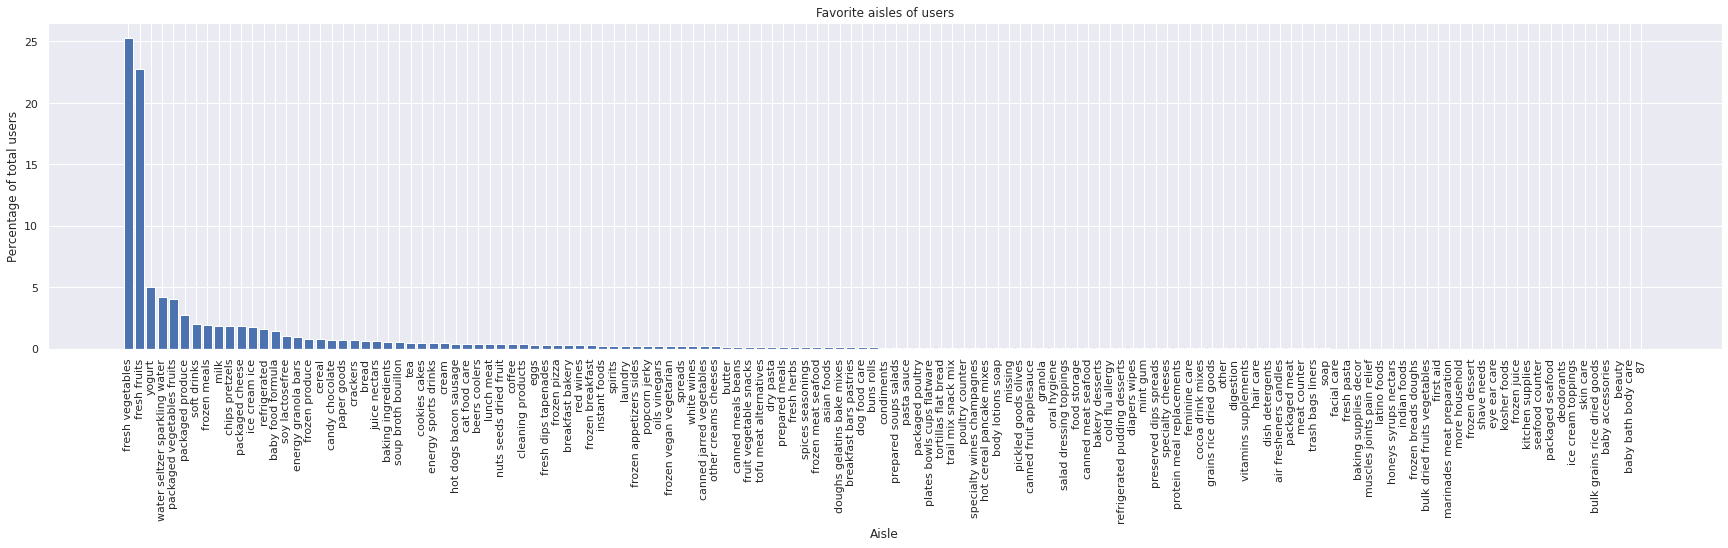

In [ ]:
vc = user_fav_aisle_df['aisle'].value_counts()
plt.bar(x=vc.index, height=vc.values / user_fav_aisle_df.shape[0] * 100)
plt.title('Favorite aisles of users')
plt.xlabel('Aisle')
plt.ylabel('Percentage of total users')
plt.xticks(rotation=90)
plt.gcf().set_size_inches(30, 6)
plt.show()

We see that fresh fruits and vegetables are the most common favorite aisles, which supports our previous findings.

# Recency-Frequency Analysis and Fitting Predictive Models using the `lifetimes` library

Next, we're going to do some recency-frequency analysis of user's purchases and attempt to predict if/when they will place another order. 

To do this, we're going to need to transform our `orders` dataset to create a `datetime` column for each user's transaction. We have enough information to build this using each customer's `order_number` and `days_since_last_order`. The reason we need this is so that we can place each customer's order in an arbitrary point in time. The year will be 1970 by default, but that doesn't matter.

In [ ]:
orders2 = orders[['user_id', 'order_number', 'days_since_prior_order', 'order_hour_of_day']]

In [ ]:
warnings.filterwarnings('ignore')
orders2['order_time'] = 0

In [ ]:
orders2 = orders2.fillna(0)
orders2['order_time'] = orders2.sort_values(by = ['user_id', 'order_number']).groupby('user_id')['days_since_prior_order'].transform(pd.Series.cumsum)

In [ ]:
orders2['order_datetime'] = pd.to_datetime(orders2['order_time'], unit = 'D')

We could make this even more precise and use the hour of day that the order was made on, but for the purpose of the analysis that we're about to do, that information is irrelevant.




In [ ]:
orders2.head(20)

user_id  order_number  days_since_prior_order  order_hour_of_day  \
0         1             1                     0.0                  8   
1         1             2                    15.0                  7   
2         1             3                    21.0                 12   
3         1             4                    29.0                  7   
4         1             5                    28.0                 15   
5         1             6                    19.0                  7   
6         1             7                    20.0                  9   
7         1             8                    14.0                 14   
8         1             9                     0.0                 16   
9         1            10                    30.0                  8   
10        1            11                    14.0                  8   
11        2             1                     0.0                 11   
12        2             2                    10.0                 10   
13        2             3                     3.0                 10   
14        2             4                     8.0                 10   
15        2             5                     8.0                 11   
16        2             6                    13.0                  9   
17        2             7                    14.0                 12   
18        2             8                    27.0                 15   
19        2             9                     8.0                  9   

    order_time order_datetime  
0          0.0     1970-01-01  
1         15.0     1970-01-16  
2         36.0     1970-02-06  
3         65.0     1970-03-07  
4         93.0     1970-04-04  
5        112.0     1970-04-23  
6        132.0     1970-05-13  
7        146.0     1970-05-27  
8        146.0     1970-05-27  
9        176.0     1970-06-26  
10       190.0     1970-07-10  
11         0.0     1970-01-01  
12        10.0     1970-01-11  
13        13.0     1970-01-14  
14        21.0     1970-01-22  
15        29.0     1970-01-30  
16        42.0     1970-02-12  
17        56.0     1970-02-26  
18        83.0     1970-03-25  
19        91.0     1970-04-02

Our modified `orders` dataset is now ready for use with the `lifetimes` library, which uses concepts bla bla bla explain here 

In [ ]:
orders_ready = orders2[['user_id', 'order_datetime']]

In [ ]:
pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lifetimes.utils import summary_data_from_transaction_data

In [ ]:
orders_transformed = summary_data_from_transaction_data(orders_ready, customer_id_col = 'user_id', datetime_col = 'order_datetime')
orders_transformed = orders_transformed.loc[orders_transformed.frequency > 0, :]

In [ ]:
orders_transformed.head()

frequency  recency      T
user_id                           
1              9.0    190.0  365.0
2             14.0    228.0  365.0
3             12.0    144.0  365.0
4              4.0     85.0  365.0
5              4.0     46.0  365.0



*   **Frequency** means the total number of purchases that a customer made **after their first purchase**. Since we have taken out all rows corresponding to customers with Frequency 0 or less, this definition allows us to look only at repeat customers - there would otherwise be too much noise from customers that try instacart only once.
*   **Recency** is the last time that the customer was observed making an order. For example, if a customer has recency 100, they last made an order on t = 100, which is 100 days after making their first repeat purchase. t = 0 is relative to each customer.

Our observation window is one year - 365 days.



In [ ]:
from lifetimes import BetaGeoFitter

Let's fit the Beta-Geometric / Negative Binomial Distribution model to this data. This model, developped by [Fader and Hardie](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_jim_07.pdf) (and taught by Fader in STAT476) consists of a mixture of distributions that attempt to fit the historical observed data (consisting of customer purchases) and then predict each customer's propensity to make another purchase in the future. This probabilistic approach can be very effective when modeling churn and retention-type problems. In the following lines of code, we will be fitting the BG/NBD model to our `orders_transformed` data - this means picking the optimal parameters for the Beta-Geometric distribution.

In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(orders_transformed['frequency'], orders_transformed['recency'], orders_transformed['T'])

<lifetimes.BetaGeoFitter: fitted with 206203 subjects, a: 2.74, alpha: 57.49, b: 33.32, r: 4.71>

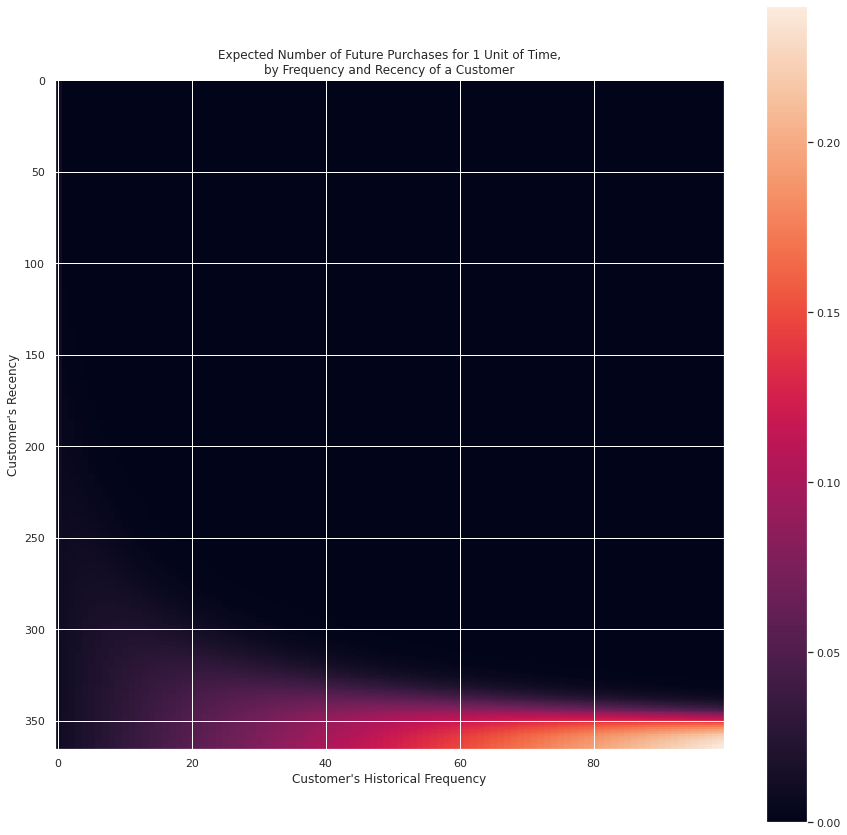

In [ ]:
from lifetimes.plotting import plot_frequency_recency_matrix
plt.figure(figsize=(15,15))
plot_frequency_recency_matrix(bgf)

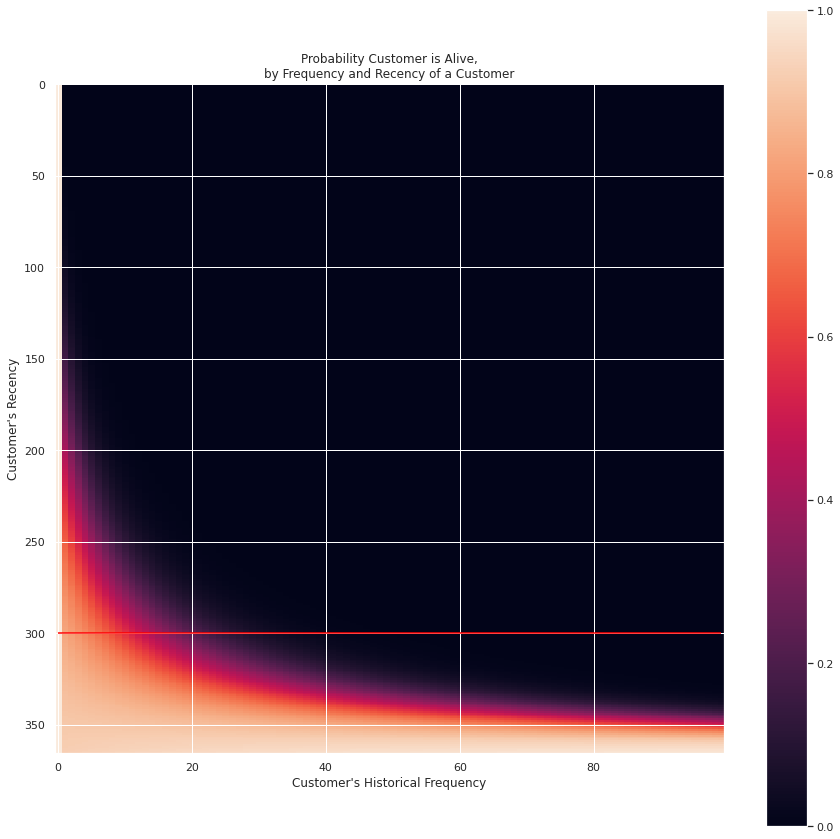

In [ ]:
from lifetimes.plotting import plot_probability_alive_matrix
plt.figure(figsize=(15,15))
plot_probability_alive_matrix(bgf)
plt.hlines(y = 300, color = 'red', xmin = 0, xmax = 99)

These heatmaps show us the relationship between customers observed recency (last time they ordered), frequency (number of times they ordered), and the fitted model's estimation of if they would order again. While this may be hard to read at first glance, it actually tells us a lot. Consider the horizontal red line drawn on the second plot. What the colors on the heatmap are telling us is that on any point on that line (in other words, for any customer with observed recency 300 - they last made an order on t=300, about two months before the end of the observation perod), they are determined to be **more likely** to still be an active user of instacart if they made **less rather than more** (further to the left on the x axis) orders over their total lifetime. Why is this the case? We will be able to visualize this better later, but based on the data that it was trained on, the model has identified patterns of users sporadically but regularly placing orders, whereas orders who place many orders in a row but then stop (and thus have a high frequency but low recency) are very unlikely to place another order. This will make more sense as we examine the data under a different light.

Let's now move onto predictions - let's use the BG/NBD model to predict each customer's probability of making another order - or in marketing terms, of still being "alive".

In [ ]:
orders_transformed['p_alive'] = bgf.conditional_probability_alive(orders_transformed['frequency'], orders_transformed['recency'], orders_transformed['T'])

We now have a column `p_alive` that corresponds to our calculated feature, which is the probability that the given customer will make another order on instacart after the observation period of the data.

Let's examine the top 10 customers determined most likely to be "alive",  and the top 10 least likely to be "alive".

In [ ]:
orders_transformed.sort_values(by='p_alive').tail(10)

frequency  recency      T   p_alive
user_id                                     
68266         96.0    365.0  365.0  0.979084
195804        96.0    365.0  365.0  0.979084
162224        97.0    365.0  365.0  0.979242
110479        97.0    365.0  365.0  0.979242
19528         97.0    365.0  365.0  0.979242
6710          98.0    365.0  365.0  0.979398
137642        98.0    365.0  365.0  0.979398
111923        98.0    365.0  365.0  0.979398
159352        99.0    365.0  365.0  0.979552
99805         99.0    365.0  365.0  0.979552

In [ ]:
orders_transformed.sort_values(by='p_alive').head(10)

frequency  recency      T       p_alive
user_id                                         
106879        92.0    120.0  365.0  1.708065e-35
180237        88.0    114.0  365.0  2.189093e-35
1024          60.0     66.0  365.0  9.152387e-34
41002         92.0    129.0  365.0  2.041360e-33
4764          94.0    133.0  365.0  3.283093e-33
183981        88.0    126.0  365.0  1.157145e-32
100935        89.0    128.0  365.0  1.399475e-32
136558        94.0    136.0  365.0  1.535111e-32
140753        89.0    130.0  365.0  3.823082e-32
205237        90.0    137.0  365.0  5.505508e-31

The "top" users are as expected - they've made close to the maximum number of orders allowed (100), and they last made an order on the very last day of the observation period.

It's very interesting to note that the users deemed most unlikely to make another purchase by our model actually have a quite high number of purchases. This is where the "recency" in frequency-recency analysis comes into play - the users in both of these cateogries have a high **frequency**, but the users deemed least likely to come back are those that last ordered a very long time ago. Let's look deeper into some of these users and their purchase history.

First, the best users.

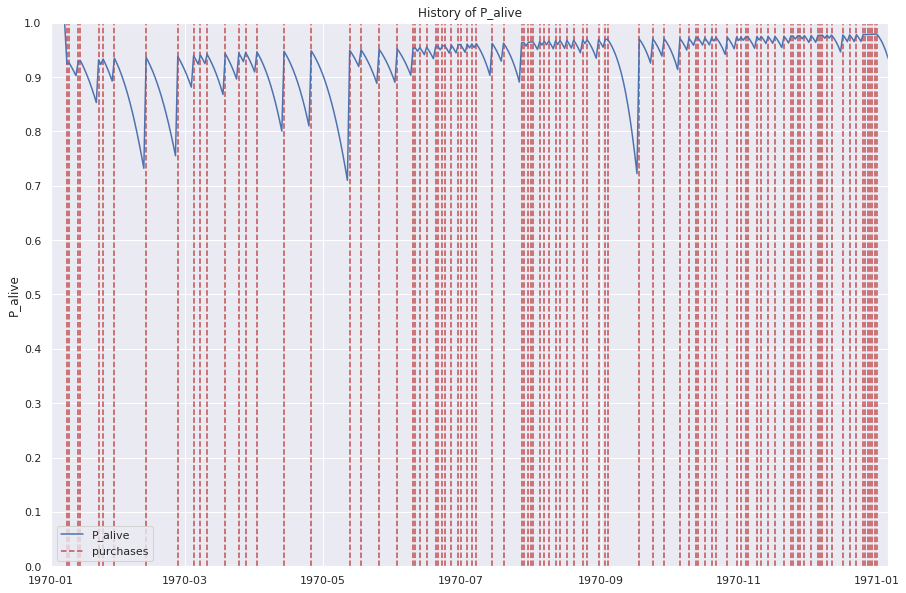

In [ ]:
from lifetimes.plotting import plot_history_alive
gu = orders_ready.loc[orders_ready.user_id == 68266]
plt.figure(figsize = (15,10))
plot_history_alive(model = bgf, t = 370, transactions = gu, datetime_col = 'order_datetime')

Each vertical red line corresponds to one order made by that customer, with time on the x axis and the model's evaluation of the probability of the customer being alive on the y axis, graphed by the blue line. We can understand why the model likes this user so much - they've regularly made purchases over the course of more than one year. They had some gaps, but they always came back. Let's look at one more "good customer" before we take a look at some of the bad ones.

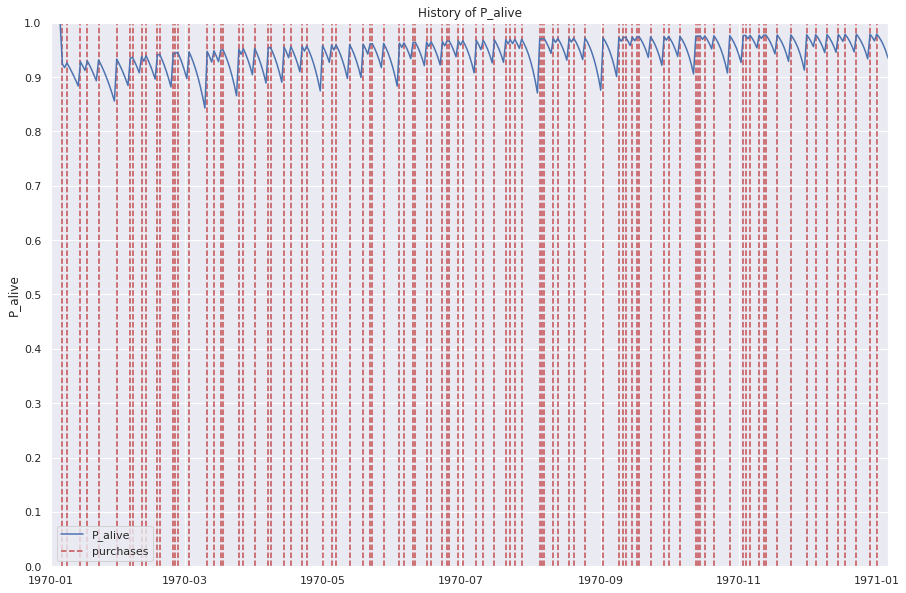

In [ ]:
gu = orders_ready.loc[orders_ready.user_id == 195804]
plt.figure(figsize = (15,10))
plot_history_alive(model = bgf, t = 370, transactions = gu, datetime_col = 'order_datetime')

This customer is also great, but it's perhaps second best because it has less of a streak of purchases right at the end of the observation period.

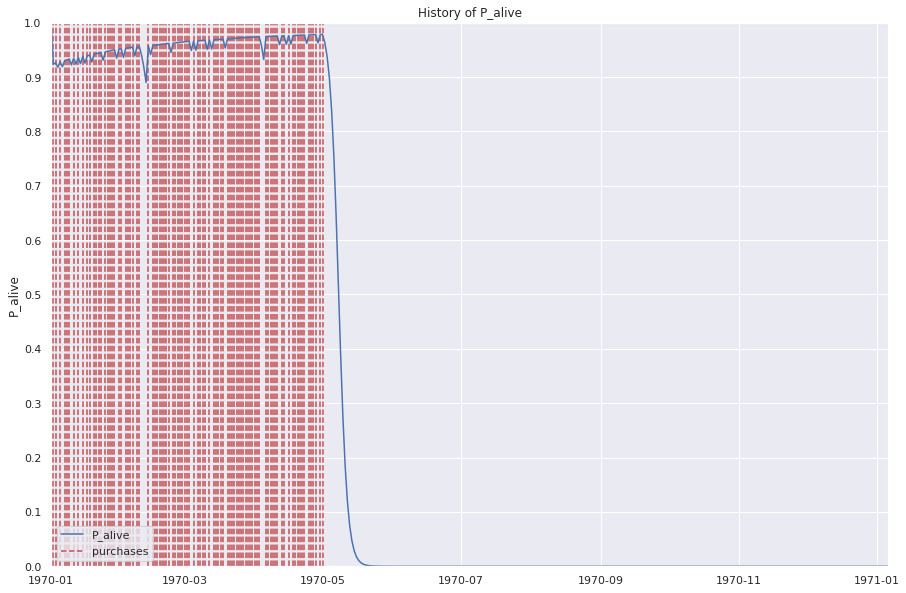

In [ ]:
bu = orders_ready.loc[orders_ready.user_id == 106879]
plt.figure(figsize = (15,10))
plot_history_alive(model = bgf, t = 370, transactions = bu, datetime_col = 'order_datetime')

It's very clear why this is the single worst customer as evaluated by the model. They ordered **a lot** at first - at a frequency even higher than the two good users we just looked at. But then, all of a sudden, after five months, completely stopped, with no orders since. The model interprets this extremely high activity followed by nothing at all as a surefire sign that the customer will not buy again, which makes sense. Let's look at the second worst user.

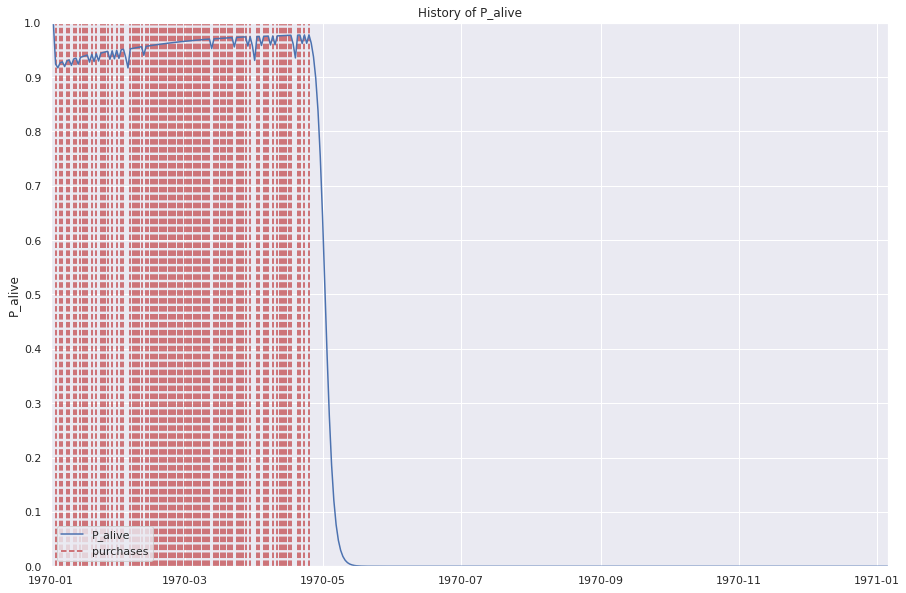

In [ ]:
bu = orders_ready.loc[orders_ready.user_id == 180237]
plt.figure(figsize = (15,10))
plot_history_alive(model = bgf, t = 370, transactions = bu, datetime_col = 'order_datetime')

Similar pattern here.

Last, it could be interesting to look at some of the other features we've created about these customers and see how they impact their buying history. Let's compare two customers, both with a relatively high number of total orders (high `frequency`), but a very different `n_unique_departments_visited`. Our hypothesis here could be that these are both regular shoppers, but one person uses instacart solely for one type of product, while the other uses it for all of their grocery needs and more. Let's see if we notice any sort of difference. Let's also join the `p_alive` feature to `grouped_user_sdf` for some context on what the model predicts about these users.

In [ ]:
grouped_user1 = pd.read_csv('grouped_user1_df.csv').drop(columns=['Unnamed: 0'])
grouped_user2 = pd.read_csv('grouped_user2_df.csv').drop(columns=['Unnamed: 0'])
grouped_user_df = grouped_user1.merge(grouped_user2, how = 'inner', on = 'user_id')
grouped_user_df = grouped_user_df[pd.to_numeric(grouped_user_df['user_id'], errors='coerce').notnull()]

In [ ]:
grouped_user_wpa = grouped_user_df.merge(orders_transformed.reset_index()[['user_id', 'p_alive']], how = 'inner', on = 'user_id')

In [ ]:
grouped_user_wpa.sort_values(['n_unique_departments_visited', 'total_orders'], ascending = [True, False]).head()

user_id  n_unique_products_ordered  n_unique_departments_visited  \
36082  201038                         37                             1   
26971   86344                          7                             1   
27966  184517                          5                             1   
47558   38492                         15                             1   
69917  175731                          9                             1   

       n_weekdays_ordered_on  n_hoursofday_ordered_on  total_orders  \
36082                      5                       10           100   
26971                      5                        6            83   
27966                      7                       19            70   
47558                      5                        9            66   
69917                      5                       10            63   

       total_items_ordered  average_days_between_orders  \
36082                  530                     3.358779   
26971                  198                     4.338462   
27966                  210                     5.130435   
47558                  274                     4.736059   
69917                  215                     6.009479   

       sd_days_between_orders   p_alive  
36082                2.526551  0.004222  
26971                2.996270  0.948089  
27966                6.268072  0.881948  
47558                4.387168  0.002565  
69917                3.062819  0.939578

In [ ]:
grouped_user_wpa.sort_values(['n_unique_departments_visited', 'total_orders'], ascending = [False, False]).head()

user_id  n_unique_products_ordered  n_unique_departments_visited  \
44735   113552                        330                            21   
40837   190887                        344                            20   
59229   138126                        305                            20   
74688     7385                        265                            20   
111406   81350                        342                            20   

        n_weekdays_ordered_on  n_hoursofday_ordered_on  total_orders  \
44735                       6                       15            53   
40837                       7                       17           100   
59229                       7                       14           100   
74688                       7                       20           100   
111406                      7                       18           100   

        total_items_ordered  average_days_between_orders  \
44735                  1053                     5.488015   
40837                  1333                     3.500759   
59229                  1659                     2.938624   
74688                   758                     2.625503   
111406                 1315                     3.963985   

        sd_days_between_orders       p_alive  
44735                 3.091472  1.262466e-04  
40837                 2.884712  7.440326e-07  
59229                 2.451885  9.457337e-20  
74688                 2.395817  2.738801e-13  
111406                2.569182  8.124401e-01

Let's compare customers `107528` and customers `25685`. They both have a very similar number of total orders (around 50), but one has only ever ordered from **one** department, while the other has ordered from **19**. How do these two shoppers differ?

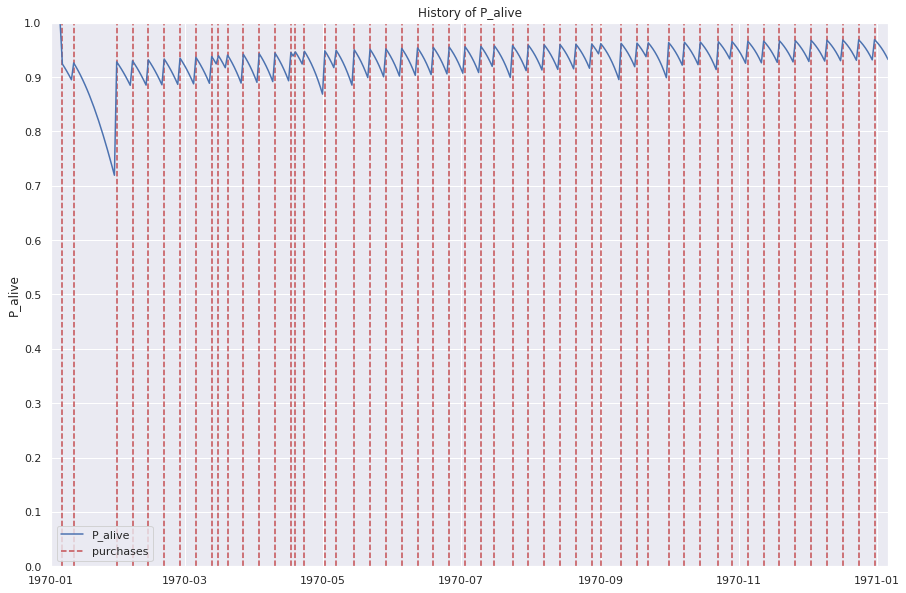

In [ ]:
odu = orders_ready.loc[orders_ready.user_id == 107528]
plt.figure(figsize = (15,10))
plot_history_alive(model = bgf, t = 370, transactions = odu, datetime_col = 'order_datetime')

Above is the customer that only ever ordered from one department. What we see is an extremely regular pattern of purchases of the course of the year, with only very few deviations. This customer has an `average_days_between_orders` of 6.89, so we can hypothesize that every week, they buy a couple or even just one item of a specific kind from one department. Let's take a look at this user's orders from our main dataset.

In [ ]:
order_products_joined = order_products_joined.drop(columns='Unnamed: 0')

In [ ]:
order_products_joined.loc[order_products_joined.user_id == 107528,:]

order_id  product_id  add_to_cart_order  reordered  \
720269       76212       10114                  1          1   
720270       76212        2820                  2          1   
1117868     117969       10114                  1          1   
1117869     117969        2820                  2          1   
1969591     207690       10114                  1          1   
...            ...         ...                ...        ...   
31706536   3344143        2820                  2          1   
32042411   3379772       10114                  1          1   
32042412   3379772        2820                  2          1   
32630581    480476       10114                  1          1   
32630582    480476        2820                  2          1   

                        product_name  aisle_id  department_id       aisle  \
720269    Classic French White Bread       112              3       bread   
720270           Francese Deli Rolls        43              3  buns rolls   
1117868   Classic French White Bread       112              3       bread   
1117869          Francese Deli Rolls        43              3  buns rolls   
1969591   Classic French White Bread       112              3       bread   
...                              ...       ...            ...         ...   
31706536         Francese Deli Rolls        43              3  buns rolls   
32042411  Classic French White Bread       112              3       bread   
32042412         Francese Deli Rolls        43              3  buns rolls   
32630581  Classic French White Bread       112              3       bread   
32630582         Francese Deli Rolls        43              3  buns rolls   

         department  user_id  order_number  order_dow  order_hour_of_day  \
720269       bakery   107528            47          4                 20   
720270       bakery   107528            47          4                 20   
1117868      bakery   107528            43          4                 11   
1117869      bakery   107528            43          4                 11   
1969591      bakery   107528            17          0                 10   
...             ...      ...           ...        ...                ...   
31706536     bakery   107528             5          5                 10   
32042411     bakery   107528            49          4                 19   
32042412     bakery   107528            49          4                 19   
32630581     bakery   107528            54          4                  9   
32630582     bakery   107528            54          4                  9   

          days_since_prior_order  
720269                       7.0  
720270                       7.0  
1117868                      7.0  
1117869                      7.0  
1969591                      2.0  
...                          ...  
31706536                     7.0  
32042411                     7.0  
32042412                     7.0  
32630581                     7.0  
32630582                     7.0  

[106 rows x 14 columns]

This person has been very methodically ordering Classic French White Bread and Francese Deli Rolls, once a week, for over a year. Impressive! Now let's take a look at the user that ordered from a more varied 19 departments.

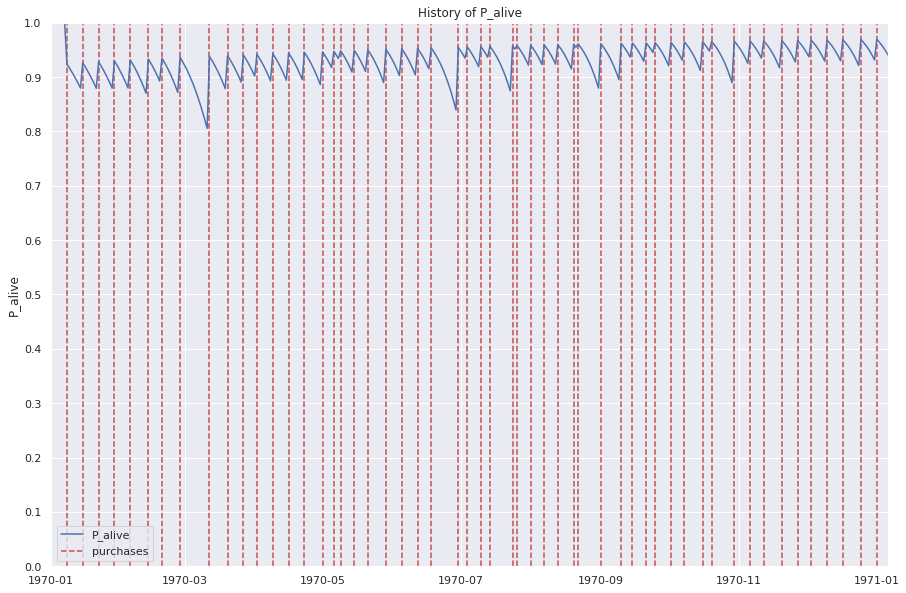

In [ ]:
from lifetimes.plotting import plot_history_alive
mdu = orders_ready.loc[orders_ready.user_id == 25685]
plt.figure(figsize = (15,10))
plot_history_alive(model = bgf, t = 370, transactions = mdu, datetime_col = 'order_datetime')

Again, a high pace of orders. Let's take a look at all of this customer's orders to see if we can pick up on anything.

In [ ]:
order_products_joined.loc[order_products_joined.user_id == 25685,:]

order_id  product_id  add_to_cart_order  reordered  \
131820       13916       24852                  1          1   
131821       13916       28204                  2          1   
131822       13916        7963                  3          1   
131823       13916       16797                  4          1   
131824       13916       12341                  5          1   
...            ...         ...                ...        ...   
33116838   1675638       23029                 22          0   
33116839   1675638       38273                 23          1   
33116840   1675638       23898                 24          1   
33116841   1675638       27344                 25          1   
33116842   1675638        9534                 26          1   

                                     product_name  aisle_id  department_id  \
131820                                     Banana        24              4   
131821                         Organic Fuji Apple        24              4   
131822              Gluten Free Whole Grain Bread        58              1   
131823                               Strawberries        24              4   
131824                              Hass Avocados        32              4   
...                                           ...       ...            ...   
33116838  Organic Uncured Sliced Black Forest Ham        96             20   
33116839                     Marinara Pasta Sauce         9              9   
33116840              Organic Gluten Free Fusilli       131              9   
33116841                     Uncured Genoa Salami        96             20   
33116842           Organic White Bread Done Right       112              3   

                         aisle       department  user_id  order_number  \
131820            fresh fruits          produce    25685            43   
131821            fresh fruits          produce    25685            43   
131822    frozen breads doughs           frozen    25685            43   
131823            fresh fruits          produce    25685            43   
131824        packaged produce          produce    25685            43   
...                        ...              ...      ...           ...   
33116838            lunch meat             deli    25685            56   
33116839           pasta sauce  dry goods pasta    25685            56   
33116840             dry pasta  dry goods pasta    25685            56   
33116841            lunch meat             deli    25685            56   
33116842                 bread           bakery    25685            56   

          order_dow  order_hour_of_day  days_since_prior_order  
131820            6                 17                     6.0  
131821            6                 17                     6.0  
131822            6                 17                     6.0  
131823            6                 17                     6.0  
131824            6                 17                     6.0  
...             ...                ...                     ...  
33116838          0                 21                     7.0  
33116839          0                 21                     7.0  
33116840          0                 21                     7.0  
33116841          0                 21                     7.0  
33116842          0                 21                     7.0  

[1247 rows x 14 columns]

As we hypothesized, looks like this is an instacart power user who just uses the service for all of their grocery needs. All sorts of products are represented here! We've just looked at two very different customers, but both surely valuable to instacart. Next, let's visualize the relationships between some of our previously calculated features and `p_alive` as calculated by our BG/NBD model.

Text(0, 0.5, 'Probability of being alive')

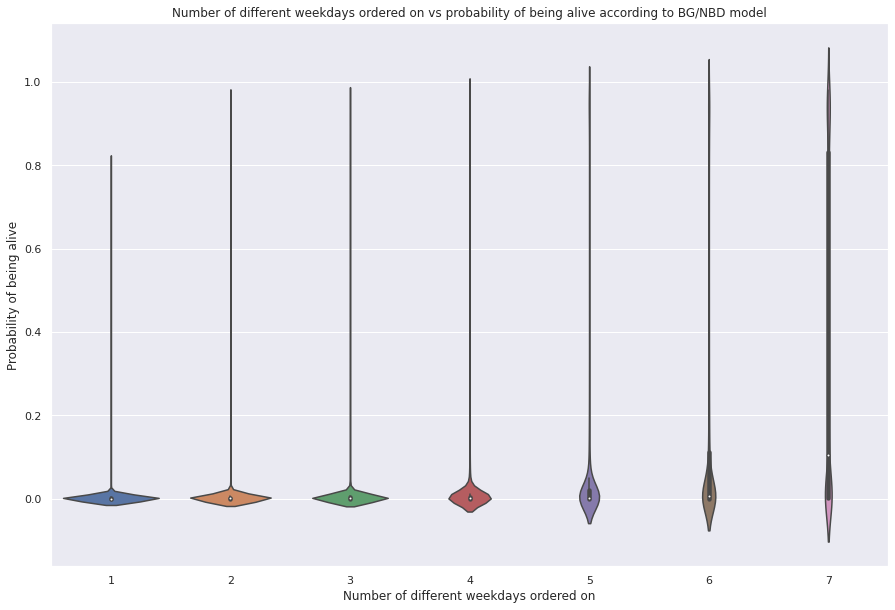

In [ ]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(15,10))
sns.violinplot(x = grouped_user_wpa['n_weekdays_ordered_on'], y = grouped_user_wpa['p_alive'])
plt.title('Number of different weekdays ordered on vs probability of being alive according to BG/NBD model')
plt.xlabel('Number of different weekdays ordered on')
plt.ylabel('Probability of being alive')

We do notice a bit of a trend, although it seems like the added benefit to `p_alive` of ordering on more different days drops off after 4 different days of the week ordered on. 

Text(0, 0.5, 'Probability of being alive')

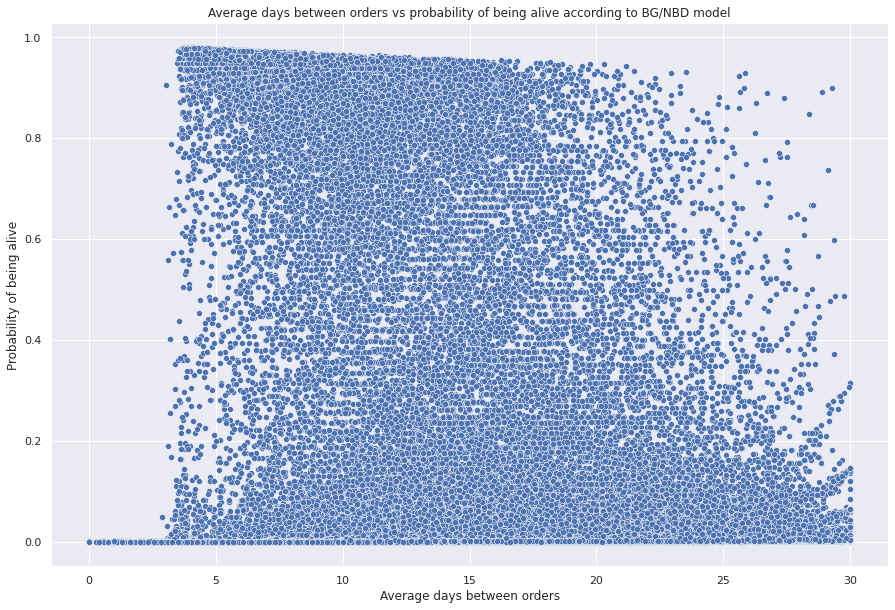

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(x = grouped_user_wpa['average_days_between_orders'], y = grouped_user_wpa['p_alive'])
plt.title('Average days between orders vs probability of being alive according to BG/NBD model')
plt.xlabel('Average days between orders')
plt.ylabel('Probability of being alive')

We don't see much of a trend here. apart from the fact that more of the points (customers) with the highest probability of being alive have a low value for `average_days_between_orders`, which makes sense and is expected.

Text(0, 0.5, 'Probability of being alive')

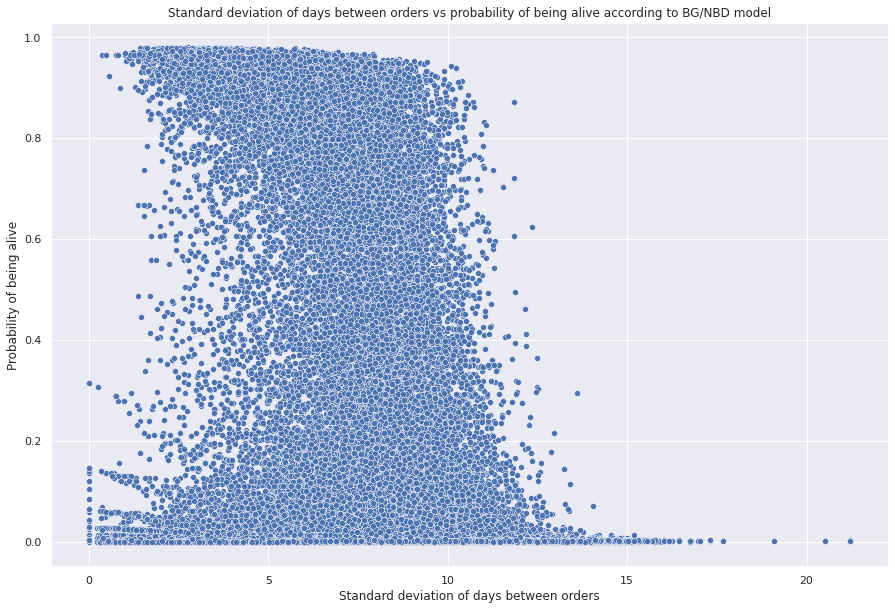

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(x = grouped_user_wpa['sd_days_between_orders'], y = grouped_user_wpa['p_alive'])
plt.title('Standard deviation of days between orders vs probability of being alive according to BG/NBD model')
plt.xlabel('Standard deviation of days between orders')
plt.ylabel('Probability of being alive')

Similar here, although the distribution of the points does have a bit more noticeable of a shape. It seems like for the points that aren't completely at 0 (corresponding to customers that have completely dropped off the radar), it's better to have a lower standard deviation of days between orders. This makes sense - more regular shoppers seem more likely to be customers for longer.

Text(0, 0.5, 'Probability of being alive')

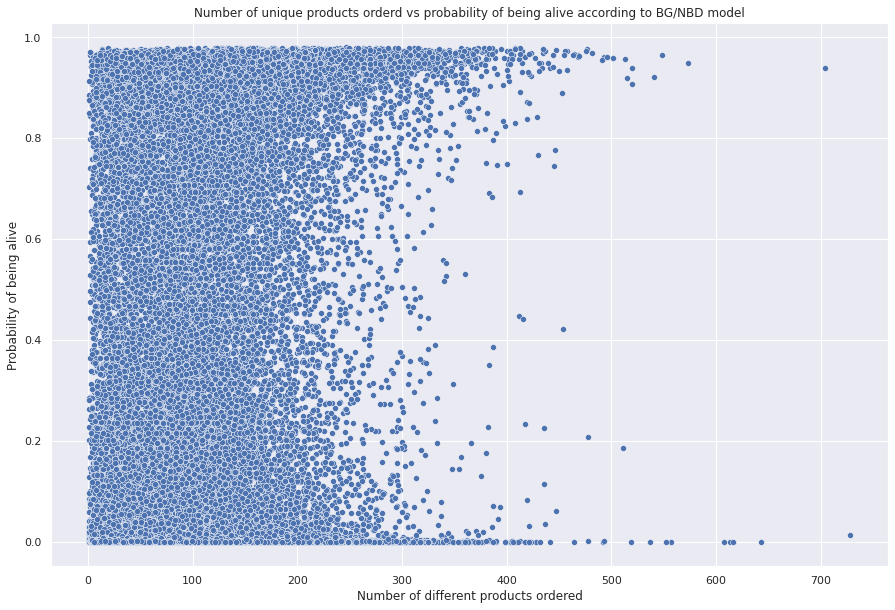

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(x = grouped_user_wpa['n_unique_products_ordered'], y = grouped_user_wpa['p_alive'])
plt.title('Number of unique products orderd vs probability of being alive according to BG/NBD model')
plt.xlabel('Number of different products ordered')
plt.ylabel('Probability of being alive')

Not much of a trend here, interestingly.

Finally, let's take a look at and visualize the value of the correlation of our `p_alive` column with all of the other features in our dataset (minus `user_id` and `p_alive` itself.


In [ ]:
palive_corr = grouped_user_wpa.corr()[['p_alive']]
palive_corr = palive_corr.drop(palive_corr.index[-1]).drop(palive_corr.index[0])

In [ ]:
palive_corr

p_alive
n_unique_departments_visited  0.276333
n_weekdays_ordered_on         0.422386
n_hoursofday_ordered_on       0.568598
total_orders                  0.638712
total_items_ordered           0.580050
average_days_between_orders  -0.274418
sd_days_between_orders       -0.118194

Text(0.5, 1.0, 'Correlation Heatmap of p_alive with other features')

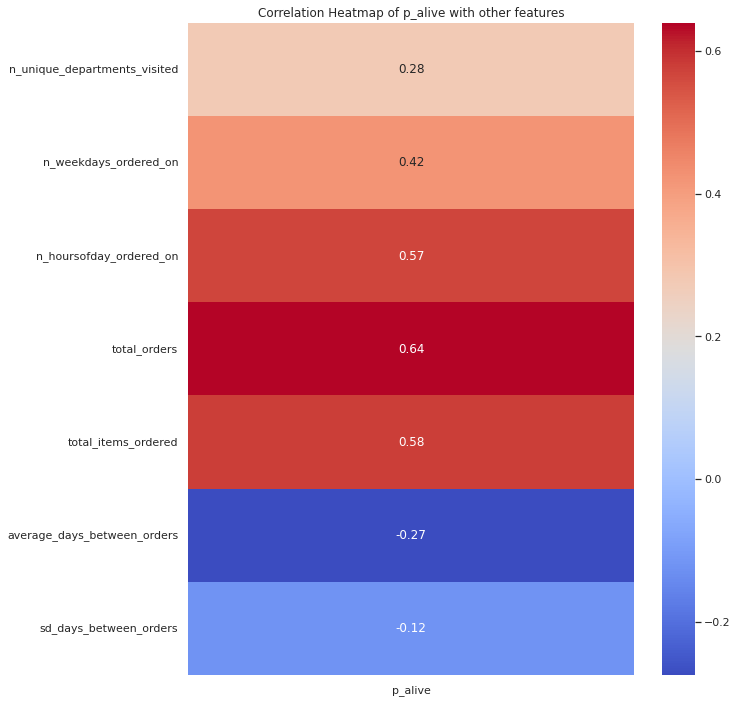

In [ ]:
plt.figure(figsize = (10,12))
sns.heatmap(palive_corr, annot = True, cmap = 'coolwarm')
plt.title("Correlation Heatmap of p_alive with other features")

As we can expect, the strongest positive correlation is with `total_orders`, `n_hoursofday_ordered_on`, and `total_items_ordered`, which are all indicators of how often people order. We notice the negative correlation with `average_days_between_orders` as previously discussed, and with `sd_days_between_orders`.

#Clustering users by aisle

Finally, let's try to classify customers according to their different purchases. Running `products.info()` shows us that there are about 50,000 unique products in the dataset. Instead of classifying customers based on the specific items that they buy, we will classify them based on the aisles that they shop in. Running `aisles.info()` shows us that there are 134 aisles. 134 features is still too many to classify customers on, so we can use PCA to find new dimensions to cluster around.

In [ ]:
df = order_products_joined

In [ ]:
cust_prod = pd.crosstab(df['user_id'], df['aisle'])

In [ ]:
cust_prod

aisle    air fresheners candles  asian foods  baby accessories  \
user_id                                                          
1                             0            0                 0   
2                             0            3                 0   
3                             0            0                 0   
4                             0            0                 0   
5                             1            4                 0   
...                         ...          ...               ...   
206205                        0            0                 1   
206206                        0            4                 0   
206207                        0            0                 0   
206208                        0            3                 0   
206209                        0            1                 0   

aisle    baby bath body care  baby food formula  bakery desserts  \
user_id                                                            
1                          0                  0                0   
2                          0                  0                0   
3                          0                  0                0   
4                          0                  0                0   
5                          0                  0                0   
...                      ...                ...              ...   
206205                     0                  0                0   
206206                     0                  0                0   
206207                     0                  1                0   
206208                     0                  3                0   
206209                     0                  0                0   

aisle    baking ingredients  baking supplies decor  beauty  beers coolers  \
user_id                                                                     
1                         0                      0       0              0   
2                         2                      0       0              0   
3                         0                      0       0              0   
4                         0                      0       0              0   
5                         0                      0       0              0   
...                     ...                    ...     ...            ...   
206205                    0                      0       0              0   
206206                    4                      1       0              0   
206207                    0                      0       0              0   
206208                    4                      0       0              0   
206209                    0                      0       0              0   

aisle    ...  spreads  tea  tofu meat alternatives  tortillas flat bread  \
user_id  ...                                                               
1        ...        1    0                       0                     0   
2        ...        3    1                       1                     0   
3        ...        4    1                       0                     0   
4        ...        0    0                       0                     1   
5        ...        0    0                       0                     0   
...      ...      ...  ...                     ...                   ...   
206205   ...        0    0                       0                     0   
206206   ...        1    0                       0                     0   
206207   ...        3    4                       0                     2   
206208   ...        5    0                       0                     7   
206209   ...        0    0                       0                     0   

aisle    trail mix snack mix  trash bags liners  vitamins supplements  \
user_id                                                                 
1                          0                  0                     0   
2                          0                  

PCA is not scale invariant, so we need to standardize the features in our data before applying PCA. 

In [ ]:
scaler = StandardScaler()
data_rescaled = scaler.fit_transform(cust_prod)
data_rescaled

array([[-0.13497103, -0.33922718, -0.07575701, ..., -0.37143228,
        -0.08668691, -0.28458752],
       [-0.13497103,  0.86951805, -0.07575701, ..., -0.19699129,
        -0.08668691,  1.85881583],
       [-0.13497103, -0.33922718, -0.07575701, ..., -0.19699129,
        -0.08668691, -0.39175769],
       ...,
       [-0.13497103, -0.33922718, -0.07575701, ...,  0.58799319,
        -0.08668691,  0.41201857],
       [-0.13497103,  0.86951805, -0.07575701, ..., -0.37143228,
        -0.08668691,  1.37655008],
       [-0.13497103,  0.06368789, -0.07575701, ..., -0.37143228,
        -0.08668691, -0.23100244]])

We would like for the explained variance (the discrepancy between our model and the actual data) to be between 95 and 99%. 

Principal components explain a part of the variance. Now we want to know about the explained variance and plot the cumulative variance against the number of components to understand which are crucial.

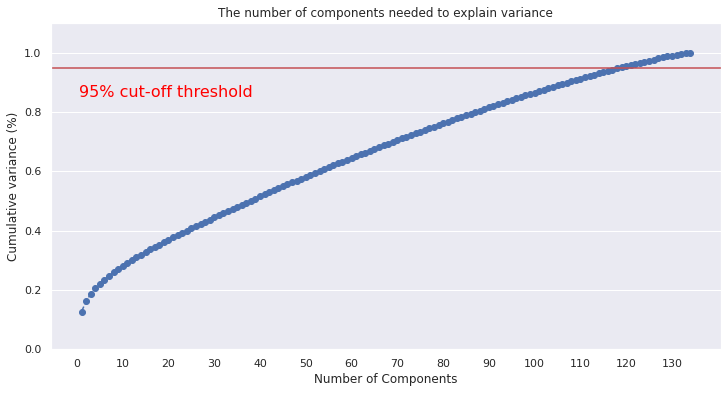

In [ ]:
pca = PCA().fit(data_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 135, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 135, step=10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

On the plotted chart, we see what number of principal components we need. About 115! This may seem extremely high, but remember, PCA only works on continuous variables.

Let's go ahead and perform PCA/clustering on our data.

In [ ]:
pca = PCA(n_components=0.95)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)
ps = pd.DataFrame(pca_samples)

We can try out several pairs of components to find the best one for a K Means Clustering. We'll use the pair at (PC4, PC1), which is representative of our original dataset.

In [ ]:
ps.head()

0          1          2          3         4         5         6   \
0 -24.811636   3.449193  -1.611615  -0.470783  0.499453 -1.889440  2.687183   
1  10.331587  39.529396   4.610970  14.683960 -7.375516 -2.020537  7.623233   
2  -9.247469   2.382711 -11.077053   0.846668 -0.395424 -2.786379 -6.674870   
3 -29.242883  -0.880035  -1.984256   2.315426 -0.296220  0.979965  0.805101   
4 -19.186003  -3.037864   0.186761   3.651016  0.856534 -2.306499 -5.230096   

         7         8          9   ...        34        35        36        37  \
0 -3.662261 -2.662647  -1.401963  ... -2.821211 -1.839530  0.151958 -4.038391   
1  4.111820 -9.993317 -12.403202  ... -2.373034  1.267245  2.247229  1.047980   
2  6.068695 -2.150027  -1.613356  ... -1.228414 -2.056462 -0.160183 -0.836928   
3  0.717956  0.037697  -0.867514  ...  0.477206 -0.506430 -0.467647  0.040474   
4  2.246232  0.926107   3.349512  ... -0.575931  0.679563  0.525401 -0.211503   

         38        39        40        41        42        43  
0 -1.367530 -1.219455 -1.763834 -0.156548 -0.489194  0.274399  
1 -0.539787 -0.132645  0.590655 -0.005066  3.299560 -0.572742  
2 -0.203685 -0.927537  0.740774 -0.175537 -1.398979 -0.223805  
3 -0.043159 -0.185886  0.044648  0.094971  0.196923  0.157595  
4 -0.084594 -0.138313 -0.179943 -0.365570  0.218587 -0.125844  

[5 rows x 44 columns]

In [ ]:
tocluster = pd.DataFrame(ps[[4,1]])

How do we know that the number of clusters we have is appropriate? We can use the Elbow Method to find the optimal number of clusters. 

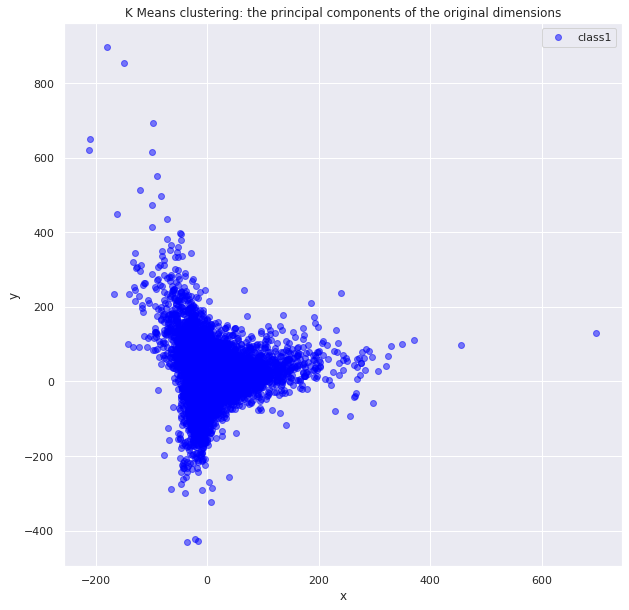

[[  0.29704457   0.11669432]
 [ -0.43154198  60.99204996]
 [ -4.21314523 -39.4298079 ]]


In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(tocluster[4], tocluster[1], 'o', color='blue', alpha=0.5, label='class1')

plt.xlabel('x')
plt.ylabel('y')
plt.title('K Means clustering: the principal components of the original dimensions')
plt.legend()
plt.show()

clusters = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusters.cluster_centers_
c_preds = clusters.predict(tocluster)
print(centers)

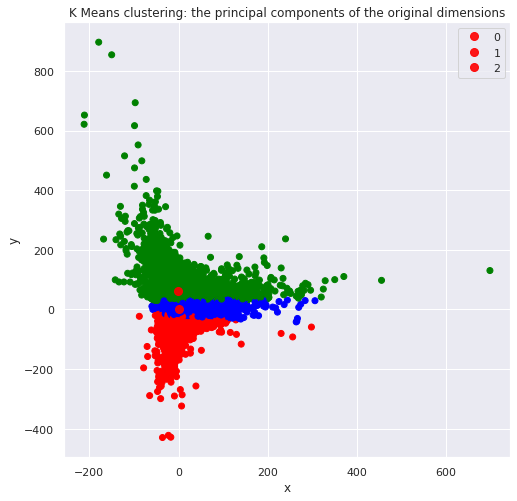

In [ ]:

fig = plt.figure(figsize=(8,8))
colors = ['blue','green','red','yellow', 'pink', 'purple']
colored = [colors[k] for k in c_preds]


clusters = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusters.cluster_centers_
c_preds = clusters.predict(tocluster)
#print(centers)

plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('K Means clustering: the principal components of the original dimensions')

plt.show()

Ok, great! We found a possible clustering of customers. Let's check if there's any sort of discernable rhythme or reason to our groups.

(206209, 135)


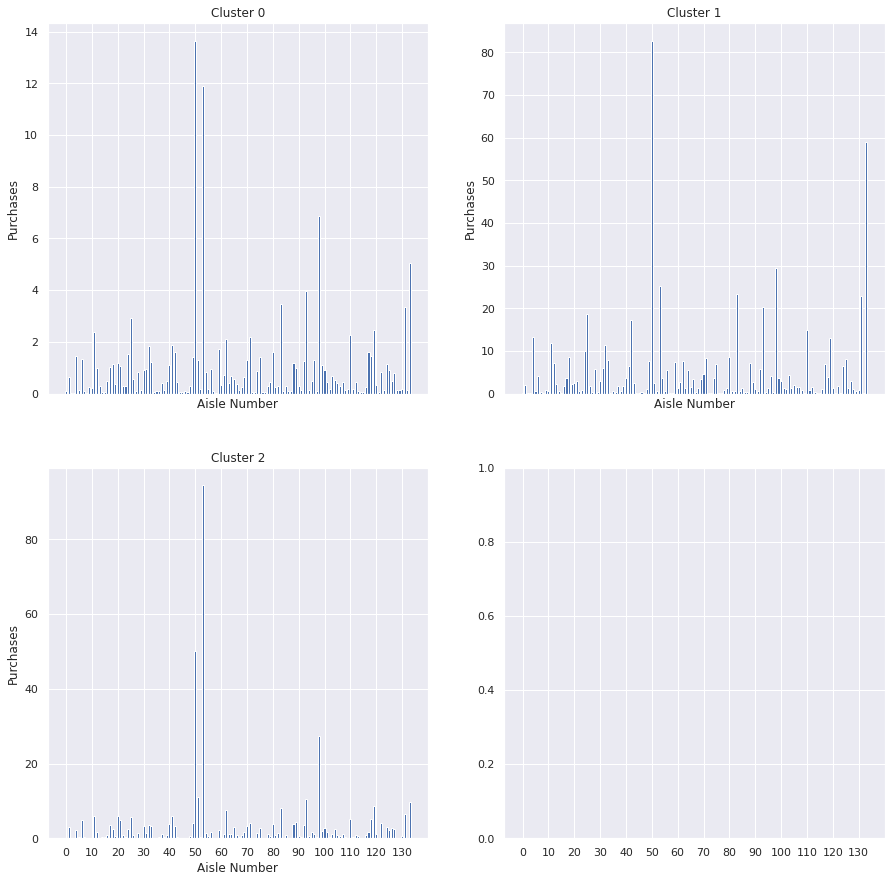

In [ ]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds
print (clust_prod.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c_0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c_0)
c_1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c_1)
c_2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c_2)

plt.xticks(np.arange(0, 135, step=10)) #change from 0-based array index to 1-based human-readable label
arr[1, 0].set_xlabel('Aisle Number')
arr[1, 0].set_ylabel('Purchases')
arr[1, 0].set_title('Cluster 2')


arr[0, 0].set_xlabel('Aisle Number')
arr[0, 0].set_ylabel('Purchases')
arr[0, 0].set_title('Cluster 0')

arr[0, 1].set_xlabel('Aisle Number')
arr[0, 1].set_ylabel('Purchases')
arr[0, 1].set_title('Cluster 1')
plt.show()

It's obvious that our three clusters share some similarities while also being distinctly different. We'll get more information if we look at the top 20 aisles purchased by the consumers in each cluster.

In [ ]:
c_0.sort_values(ascending=False)[0:20]

aisle
fresh fruits                     13.652683
fresh vegetables                 11.877410
packaged vegetables fruits        6.884299
yogurt                            5.030123
packaged cheese                   3.959837
milk                              3.461912
water seltzer sparkling water     3.339166
chips pretzels                    2.911818
soy lactosefree                   2.466981
bread                             2.387550
refrigerated                      2.265836
ice cream ice                     2.178164
frozen produce                    2.112823
eggs                              1.871493
crackers                          1.854128
frozen meals                      1.736774
energy granola bars               1.622115
lunch meat                        1.617035
soft drinks                       1.614447
cereal                            1.547103
dtype: float64

In [ ]:
c_1.sort_values(ascending=False)[0:20]

aisle
fresh fruits                     82.801124
yogurt                           58.961192
packaged vegetables fruits       29.510127
fresh vegetables                 25.269437
milk                             23.419051
water seltzer sparkling water    22.843721
packaged cheese                  20.345877
chips pretzels                   18.552594
energy granola bars              17.144910
refrigerated                     14.873122
baby food formula                13.150921
soy lactosefree                  12.926173
bread                            11.955181
crackers                         11.455508
cereal                            9.942506
candy chocolate                   8.500588
lunch meat                        8.468444
ice cream ice                     8.391872
tea                               8.014765
cream                             7.944728
dtype: float64

In [ ]:
c_2.sort_values(ascending=False)[0:20]

aisle
fresh vegetables                 94.439068
fresh fruits                     50.038321
packaged vegetables fruits       27.266380
fresh herbs                      10.984249
packaged cheese                  10.414793
yogurt                            9.705935
soy lactosefree                   8.615816
milk                              8.093692
frozen produce                    7.631891
water seltzer sparkling water     6.612324
eggs                              6.069497
canned jarred vegetables          5.967443
bread                             5.871641
chips pretzels                    5.639523
refrigerated                      5.139076
soup broth bouillon               5.036048
baking ingredients                4.902330
canned meals beans                4.829991
oils vinegars                     4.494195
ice cream ice                     4.158399
dtype: float64

Ok, this is super interesting. All three of our clusters include fresh fruits and vegetables, which makes sense given our earlier findings that fresh produce accounts for nearly 30% of all purchases.

Our clusters also show that the aisles of

*   Fresh vegetables
*   Fresh fruits
*   Packaged vegetables fruits
*   Yogurt
*   Milk
*   Bread
*   Refrigerated
*   Soy and lactose free


are preserved across all clusters. This is consistent with our findings from EDA: these aisles are also the most frequently purchased from. 







# Clustering users by ordering behavior

Now, let's use the grouped_user datasets we created using spark to do some more clustering analysis, this time on individual users. Let's first import our datasets (which were outputted in several pieces due to memory concerns), clean them a little, and join the dataset we made with each user's favorite department. This will be a great feature to get an indication on the tastes of each user. It's also good because this feature has a relatively low number of categories (23), compared to aisles and individual products. This makes the one-hot encoding step less cumbersome. This time, we'll try out our clustering without doing PCA first.

In [ ]:
grouped_user1 = pd.read_csv('grouped_user1_df.csv').drop(columns=['Unnamed: 0'])
grouped_user2 = pd.read_csv('grouped_user2_df.csv').drop(columns=['Unnamed: 0'])
grouped_user3 = grouped_user1.merge(grouped_user2, how = 'inner', on = 'user_id')
grouped_user3 = grouped_user3[pd.to_numeric(grouped_user3['user_id'], errors='coerce').notnull()]
user_fav_dep = pd.read_csv('user_fav_dep_df.csv').drop(columns = ['Unnamed: 0', 'count']).drop_duplicates(subset=['user_id'])
user_fav_dep = user_fav_dep[pd.to_numeric(user_fav_dep['user_id'], errors='coerce').notnull()]

In [ ]:
grouped_user3['user_id'] = grouped_user3.user_id.astype('int')
user_fav_dep['user_id'] = user_fav_dep.user_id.astype('int')

Let's now get dummy variables for each user's favorite department - that'll enable us to use it properly for the clustering step.

In [ ]:
user_fav_dep = pd.get_dummies(user_fav_dep, columns = ['department'])

In [ ]:
grouped_user4 = grouped_user3.copy().set_index('user_id')
columns = grouped_user4.columns
scaler = StandardScaler()
grouped_user4[columns] = scaler.fit_transform(grouped_user4[columns])
grouped_user4 = grouped_user4.reset_index()

In [ ]:
grouped_user_final = grouped_user4.merge(user_fav_dep, how = 'inner', on = 'user_id')

In [ ]:
grouped_user_final = grouped_user_final.set_index('user_id')

This is the final version of the dataset that we'll be running our clustering on.

In [ ]:
grouped_user_final.shape

(206037, 29)

Let's tune our k-means model and decide how many centroids to use.

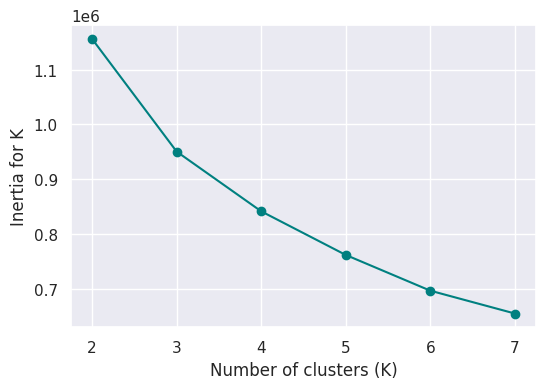

In [ ]:
inertia = []
for k in range(2, 8):
    kmeans1 = KMeans(n_clusters=k)
    kmeans1.fit(grouped_user_final)
    inertia.append(kmeans1.inertia_)
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(range(2, 8), inertia, color="teal", marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia for K")
plt.show()

Not too clear on where an elbow/knee is here, but let's go with 4.

In [ ]:
kmeans_final = KMeans(n_clusters = 4, random_state=0)
kmeans_final.fit(grouped_user_final)

KMeans(n_clusters=4, random_state=0)

Let's add each user's assigned cluster as a column to our main dataset - it'll help us understand what each cluster means. We want to be looking at the non-standardscaled dataset though, so we can actually see "real" values for all of the features. So let's use `grouped_user_wpa` from the recency-frequency analysis section as a starting point.

In [ ]:
grouped_user_fc = grouped_user_final.reset_index()
grouped_user_fc['cluster'] = kmeans_final.labels_
grouped_user_wpa_wc = grouped_user_wpa.merge(grouped_user_fc[['user_id', 'cluster']], how = 'inner', on = 'user_id')

In [ ]:
grouped_user_wpa_wc.shape

(130981, 11)

Let's start plotting the relationship between the features in the dataset, with the added dimension of the cluster each datapoint is in. Let's see if we pick up on any trends.

But even before that, let's see how many datapoints are in each cluster.

In [ ]:
cluster_counts = grouped_user_wpa_wc.groupby('cluster').count()[['user_id']]
cluster_counts['percentage'] = round((cluster_counts.user_id / cluster_counts.user_id.sum()) * 100,2)
cluster_counts

user_id  percentage
cluster                     
0          27475       20.98
1          41532       31.71
2          13046        9.96
3          48928       37.36

Looks like the clusters are relatively even, with the largest cluster being cluster 3, followed by 1, 0, and finally 2.


Let's move on to visualizations of features.

Text(0, 0.5, 'Total orders')

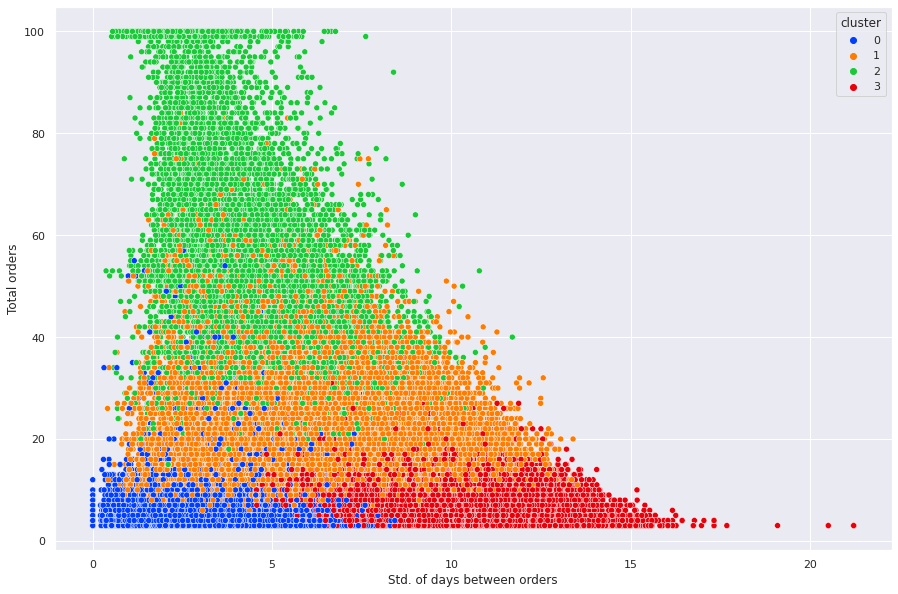

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(x = 'sd_days_between_orders', y = 'total_orders', 
                data = grouped_user_wpa_wc, hue = 'cluster', palette = 'bright')
plt.xlabel('Std. of days between orders')
plt.ylabel('Total orders')

Text(0, 0.5, 'Total orders')

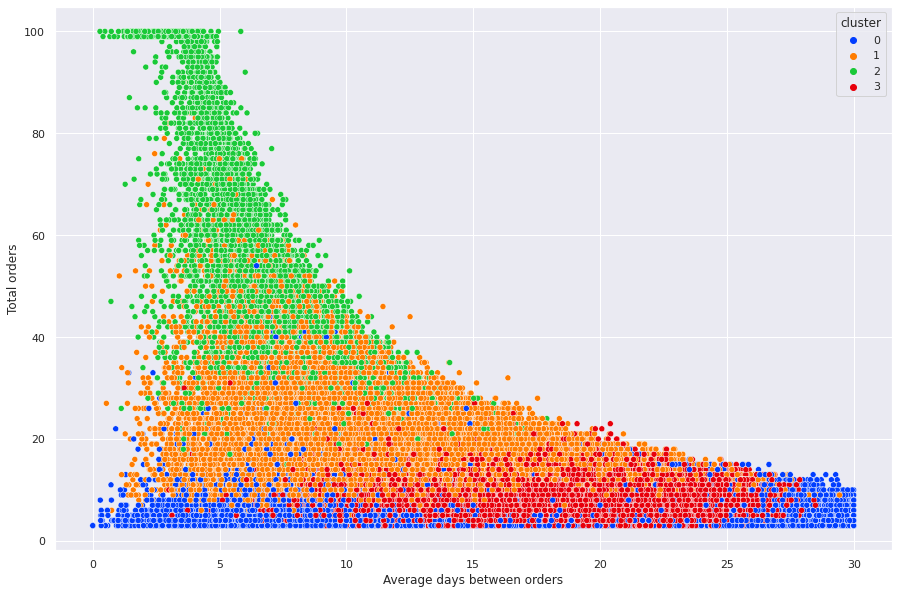

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(x = 'average_days_between_orders', y = 'total_orders', 
                data = grouped_user_wpa_wc, hue = 'cluster', palette = 'bright')
plt.xlabel('Average days between orders')
plt.ylabel('Total orders')

Not much here either.

Text(0, 0.5, 'Number of weekdays ordered on')

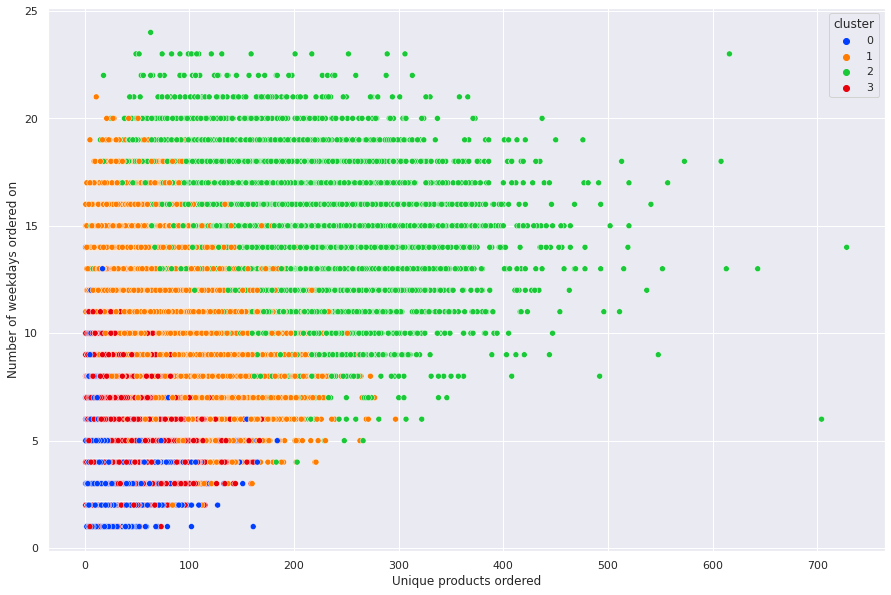

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(x = 'n_unique_products_ordered', y = 'n_hoursofday_ordered_on', 
                data = grouped_user_wpa_wc, hue = 'cluster', palette = 'bright')
plt.xlabel('Unique products ordered')
plt.ylabel('Number of weekdays ordered on')

Text(0, 0.5, 'Total different items ordered')

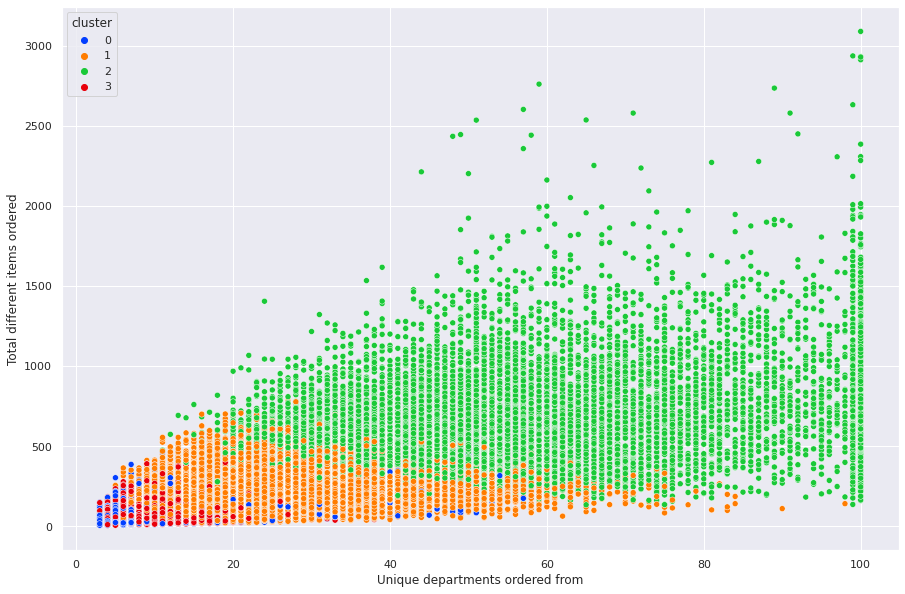

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(x = 'total_orders', y = 'total_items_ordered', 
                data = grouped_user_wpa_wc, hue = 'cluster', palette = 'bright')
plt.xlabel('Unique departments ordered from')
plt.ylabel('Total different items ordered')

Let's now see if the clusters correlate at all with the predictions we made earlier, and our calculated `p_alive` feature - which evaluates if a customer is likely to make another order on instacart again.

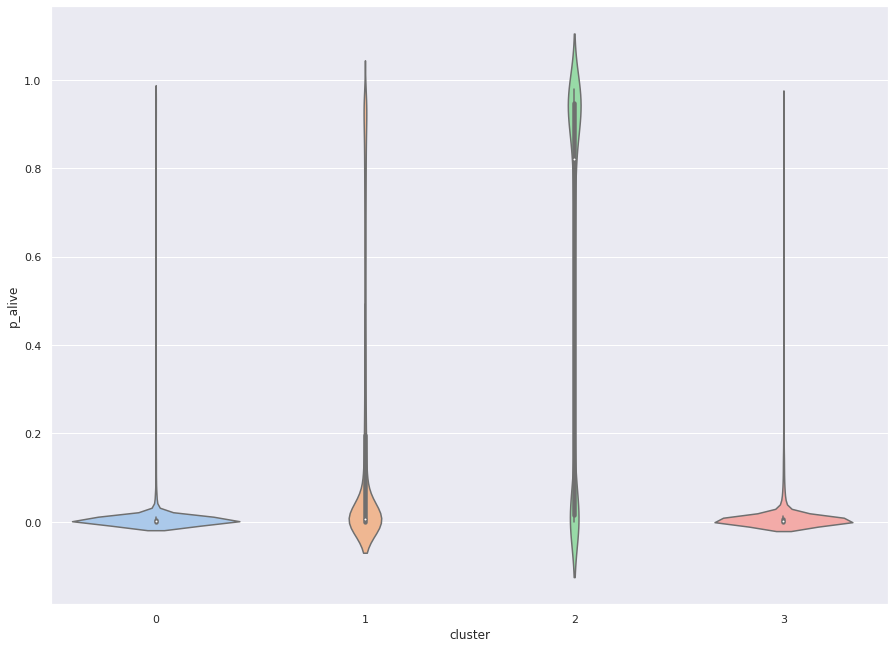

In [ ]:
plt.figure(figsize=(15,11))
sns.violinplot(x = 'cluster',  y = 'p_alive', data = grouped_user_wpa_wc, palette = 'pastel')

Interesting - it seems like most of the customers with a high `p_alive` find themselves in cluster #2. Looking at the previous visualizations, it seems like the story is that cluster 0 is the customers with the least amount of orders, cluster 2 is the regular, frequent customers who order a variety of products, cluster 3 is similar to cluster 0 but less regular, and cluster 1 is everything in between.

Let's now simply group by cluster and look at the mean of each feature.

In [ ]:
grouped_user_wpa_wc.drop(columns=['user_id']).groupby('cluster').mean()

n_unique_products_ordered  n_unique_departments_visited  \
cluster                                                            
0                        29.190136                      8.227662   
1                        87.133584                     13.032385   
2                       180.434616                     15.195386   
3                        41.440995                      9.884688   

         n_weekdays_ordered_on  n_hoursofday_ordered_on  total_orders  \
cluster                                                                 
0                     3.282002                 4.148644      5.634359   
1                     6.081600                 9.860493     20.900438   
2                     6.694082                14.002453     54.144719   
3                     4.154206                 5.537157      8.050625   

         total_items_ordered  average_days_between_orders  \
cluster                                                     
0                  47.246042                    19.386786   
1                 202.645912                    12.367173   
2                 643.675686                     7.168193   
3                  68.595038                    18.585015   

         sd_days_between_orders   p_alive  
cluster                                    
0                      3.164044  0.012642  
1                      7.259739  0.173282  
2                      4.654158  0.570067  
3                      9.180108  0.022318

This gives us some additional insight into what these clusters mean, and confirms our hypothesis. Cluster 2 is the cluster that instacart wishes every customer was. Lots of orders, orders on many different days, across many different types of products, but yet regular (second-lowest `sd_days_between_orders` among the four clusters). They have the highest `p_alive` as a group, with an impressive 57%, compared to 1.3% and 2.2% for clusters 0 and 3. Cluster 1 has a respectable 17.3% `p_alive` on average. 

It's definitely interesting and insightful that this unsupervised clustering ended up translating into identifying groups of customers that seemed correlated with our findings in the prediction section, and would lead us to think that this clustering was a success!

# **Conclusions**

## **EDA**

We used EDA to discover trends and patterns about the data, as well as to confirm and deny our assumptions about the types of foods people order while grocery shopping online. Our visualizations helped us understand how variables were related to each other and distributed within our dataset. Some key insights include

* Barplots of the hour of the day and the frequency of order placement showed that customers most often placed orders during the middle of the day, between 10 and 5 PM.
* The distribution of the order frequency vs. day of the week was somewhat uniform, with more activity on the weekend.
* Many users go more than a month between consecutive order, but the consecutive order frequencies also peak at 7 days; i.e. weekly. Some customers are more regular than others.
* We also saw a heavily right-skewed distribution of number of orders that customers have made, indicating that most customer aren't regular (or even alive).


## **Recency-Frequency Analysis**

In this section we transformed our dataset, leveraging the `days_since_prior_order` feature to construct a time-series view of the data. We then used the `lifetimes` package to predict each customer's probability of making another order on instacart, based on their observed transaction history. This analysis both took into account the volume of their transactions as well as its timining. Overall, we identified customers that seemed most likely to return to instacart. Our biggest finding here was that among those top customers, there was no clear pattern in terms of shopping habits (times of day, days of week, and time between orders) or shopping tastes (types of products ordered), with some customers making nearly 100 orders all from the same department while others ordered a variety of products.


## **Clustering Users by Aisle**

Our cluster-by-aisle model performed relatively well. We analyzed customers not only the aisles they shopped in but also by the quantity of goods they purchased. We noticed that each of the clusters shared several aisles, such as fruits, vegetables, milk, bread, and packaged cheese with the other clusters. Our clusters were consistent with our EDA results: the popularity of aisles is a heavily right-tailed distribution, and it makes sense that shoppers would largely all visit some common aisles. However, we did also find that shoppers of cluster 0 bought markedly fewer items than shoppers of clusters 1 and 2. Shoppers in Cluster 1 bought more yogurt than shoppers in any other cluster, and both shoppers in cluster 1 and 2 bought lots of food from the 'baby food and formula aisle', despite that aisle not being very popular overall.  

## **Clustering Users by Ordering Behavior**
This model, which performed the clustering on the dataset grouped by `user_id`, was also successful. finding a total of four clusters. When we compared our clusters with the findings in the recency-frequency analysis section, we found that one of the clusters actually contained many of the customers determined to have a high proability of making another purchase. Overall, it was encouraging to find that the results of this unsupervised learning were coherent with the findings of our predictive analysis.

## **Next Steps** 

We could try to import nutrition information and see which aisles and products are the most nutritionally dense, create categorical variables to rank the healthiness of foods (based on data such as their added sugar content, the number of ingredients, and their sodium daily value percentages) and then perform more clustering to see if users can be grouped by the healthiness of their order.

We could also try to predict which products would be in a user's next order. Along those lines, we could try to find which products were highly correlated and then create personalized recommendation system algorithms for users.

If there were a way for us to acquire the specific dates at which each purchase was made (that is, if we knew the month and the year in addition. tothe hour and the day of the week), we could also perform time series analysis to see which foods were trending at which times, and also to make predictions about future popular items. We could also make predictions about the popularity of InstaCart itself, or add data from other online grocery shopping services to compare the popularity of different companiesin the grocery delivery space, as well as offer a prediction for the popularity of ionline grocery shopping in general.

Finally, while we were able to use the lifetimes library to predict *if* a customer would order again, we would also have liked to create a model to predict *when* a user would order again (i.e. number of days since their most recent order they would wait before ordering again), given their previous order history. To create/evaluate this model, we would have done the following (given more time):
1. For each user with at least 2 orders, take every user's most recent order from the order products data frame. Create a data frame containing the days between orders for each such order (one for each user). This quantity is our dependent variable.
2. Perform the same user group-by processing on the remaining orders as we did in the "Processing the data with Spark" section. This should yield a user-level data frame containing aggregate information about every user's order history (i.e. excluding their most recent order). This array is our predictor array.
3. Join this data frame with the data frame we created in the first step (by `user_id`). This is our dataset for our predictive model. From here, we can drop the `user_id` column and perform a train-test split with the aforementioned dependent variable (number of days waited before a user made their most recent purchase). Then, we can fit a variety of regression models as we please.